## Udacity Vehicle Detection Project -P5

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally,  apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from moviepy.editor import VideoFileClip
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import time
#%matplotlib qt
%matplotlib inline

Create a list of Vehicle and Non Vehicle list

In [2]:
cars = []
notcars = []
#carimgs = glob.glob('./vehicles/KITTI_extracted/*.png')
carimgs = glob.glob('./vehicles/*/*.png')
ncarimgs = glob.glob('./non-vehicles/*/*.png')
for carimg in carimgs:
    cars.append(carimg)
for ncarimg in ncarimgs:
    notcars.append(ncarimg)


#### Data Exploration

In [3]:
#Function to Lokkup the List of Car and Non cars
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [4]:
data_dict = data_look(cars, notcars)
print ('No of Cars:',data_dict["n_cars"])
print ('No of NonCars:',data_dict["n_notcars"])
print ('Image Shape:',data_dict["image_shape"])
print ('Image Type:',data_dict["data_type"])

No of Cars: 8792
No of NonCars: 8968
Image Shape: (64, 64, 3)
Image Type: float32


#### Plot a CarImage and Non Car Image

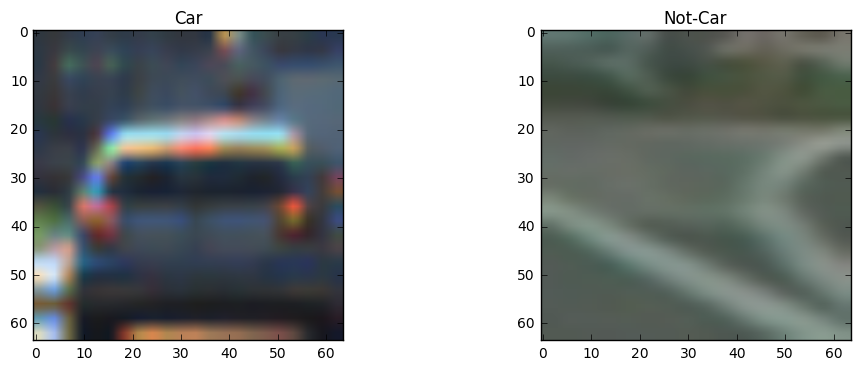

In [5]:
car_ind = np.random.randint(0, data_dict["n_cars"])
notcar_ind = np.random.randint(0, data_dict["n_notcars"])
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Car')
plt.subplot(122)
plt.imshow(mpimg.imread(notcars[notcar_ind]))
plt.title('Not-Car')

### Feature Extraction

#### Color space conversion

In [6]:
def colorspacecov(img,color_space ='RGB'):
      # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            conv_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: conv_image = np.copy(img)
    return conv_image   

### Binned Color Features

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):         
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
'''
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
'''

'\ndef bin_spatial(img, size=(32, 32)):\n    color1 = cv2.resize(img[:,:,0], size).ravel()\n    color2 = cv2.resize(img[:,:,1], size).ravel()\n    color3 = cv2.resize(img[:,:,2], size).ravel()\n    return np.hstack((color1, color2, color3))\n'

### Color Histogram

In [8]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### HOG - Histogram of Oriented Gradients

In [9]:
# http://www.learnopencv.com/histogram-of-oriented-gradients/
# http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### Combine Spatial , Color Histogram and Hog Features

In [10]:
def extract_features(imgs, cspace='RGB',spatial_size=(32, 32),hist_bins=32, orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = colorspacecov(image,color_space = cspace)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Apply Hog 
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

#### Extract all  Features and Combine

In [27]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
size=(32, 32) # 16,16
nbins = 32 # 16
n_samples = 4000
random_idxs = np.random.randint(0,len(cars),n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]
t1 = time.time()
car_features = extract_features(test_cars, cspace=colorspace,spatial_size = size,hist_bins = nbins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(test_notcars, cspace=colorspace,spatial_size = size,hist_bins = nbins,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print ('Extracting time:',t2-t1)

Extracting time: 142.02012300491333


#### Scale all the features

In [28]:
# Create an array stack of feature vectors
t1 = time.time()
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
t2 = time.time()
print ('Scaling time:',t2-t1)

Scaling time: 2.6721529960632324


#### Train Data with SVC

In [29]:

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
print('Fitting in progress...')
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

Fitting in progress...
19.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9925


### Hog Subsampling search on the window

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [30]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    out_images = []
    out_maps = []
    out_titles = []
    out_boxes = []
    img_boxes = []
    draw_img = np.copy(img)
    #Make a heat map of zeros
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    img = img.astype(np.float32)/255
    count = 0
    t = time.time()
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            complete_feature = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    print (time.time()-t,'seconds to run, Total Windows = ',count)
    return draw_img,heatmap

0.6530373096466064 seconds to run, Total Windows =  294


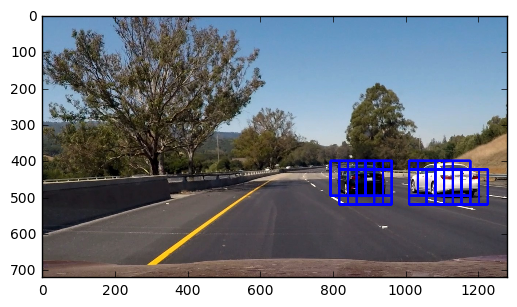

In [36]:
image_in = mpimg.imread('./test_images/test6.jpg')

ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32,32)
hist_bins = 32
    
out_img,heatmap = find_cars(image_in, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#plt.imshow(heatmap,cmap='hot')
plt.imshow(out_img)

In [43]:
import pickle
#pickle.dump( svc, open( "svcfit.p", "wb" ) )
#pickle.dump(X_scaler, open("scaler.p","wb" ))
pickle.dump(random_idxs, open("random_idxs.p","wb" ))

In [40]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [41]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### Heat map to Labels and Draw boxes 

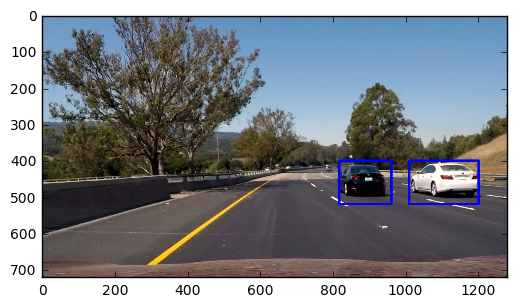

In [42]:
from scipy.ndimage.measurements import label
# Apply threshold to help remove false positives
heat = apply_threshold(heatmap,1)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image_in), labels)
plt.imshow(draw_img)

In [54]:
def processimage(img):
    ystart = 400
    ystop = 656
    scale = 1.5
    spatial_size = (32,32)
    hist_bins = 32

    out_img,heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heatmap,1)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    final_img = draw_labeled_bboxes(np.copy(img), labels)
    #plt.imshow(draw_img)
    return final_img
    #plt.imshow(heatmap,cmap='hot')


### Process Single Image

0.5670323371887207 seconds to run, Total Windows =  294


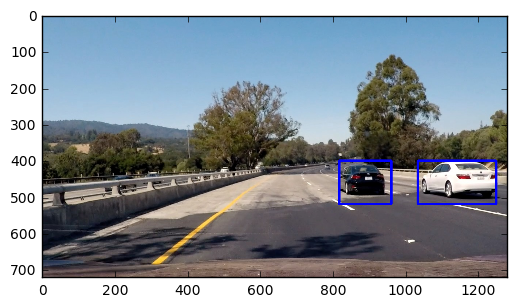

In [57]:
image_in = mpimg.imread('./test_images/test4.jpg')
final_img = processimage(image_in)
plt.imshow(final_img)

#### Video Generation

In [59]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
Out_clip = clip1.fl_image(processimage) #NOTE: this function expects color images!!
%time Out_clip.write_videofile(output, audio=False)

0.596034049987793 seconds to run, Total Windows =  294
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

0.6760385036468506 seconds to run, Total Windows =  294


  0%|                                         | 1/1261 [00:00<15:18,  1.37it/s]

0.6470370292663574 seconds to run, Total Windows =  294


  0%|                                         | 2/1261 [00:01<15:13,  1.38it/s]

0.6690382957458496 seconds to run, Total Windows =  294


  0%|                                         | 3/1261 [00:02<15:18,  1.37it/s]

0.6400365829467773 seconds to run, Total Windows =  294


  0%|▏                                        | 4/1261 [00:02<15:04,  1.39it/s]

0.604034423828125 seconds to run, Total Windows =  294


  0%|▏                                        | 5/1261 [00:03<14:46,  1.42it/s]

0.6290359497070312 seconds to run, Total Windows =  294


  0%|▏                                        | 6/1261 [00:04<14:43,  1.42it/s]

0.6190354824066162 seconds to run, Total Windows =  294


  1%|▏                                        | 7/1261 [00:04<14:31,  1.44it/s]

0.7780444622039795 seconds to run, Total Windows =  294


  1%|▎                                        | 8/1261 [00:05<15:27,  1.35it/s]

0.8880507946014404 seconds to run, Total Windows =  294


  1%|▎                                        | 9/1261 [00:06<16:46,  1.24it/s]

0.7390422821044922 seconds to run, Total Windows =  294


  1%|▎                                       | 10/1261 [00:07<16:47,  1.24it/s]

0.7440426349639893 seconds to run, Total Windows =  294


  1%|▎                                       | 11/1261 [00:08<16:47,  1.24it/s]

0.8530488014221191 seconds to run, Total Windows =  294


  1%|▍                                       | 12/1261 [00:09<17:32,  1.19it/s]

0.7580432891845703 seconds to run, Total Windows =  294


  1%|▍                                       | 13/1261 [00:10<17:33,  1.19it/s]

0.7600433826446533 seconds to run, Total Windows =  294


  1%|▍                                       | 14/1261 [00:10<17:29,  1.19it/s]

1.0300588607788086 seconds to run, Total Windows =  294


  1%|▍                                       | 15/1261 [00:12<19:08,  1.08it/s]

0.7410423755645752 seconds to run, Total Windows =  294


  1%|▌                                       | 16/1261 [00:12<18:29,  1.12it/s]

0.6950397491455078 seconds to run, Total Windows =  294


  1%|▌                                       | 17/1261 [00:13<17:39,  1.17it/s]

0.7380421161651611 seconds to run, Total Windows =  294


  1%|▌                                       | 18/1261 [00:14<17:29,  1.18it/s]

0.710040807723999 seconds to run, Total Windows =  294


  2%|▌                                       | 19/1261 [00:15<17:06,  1.21it/s]

0.703040361404419 seconds to run, Total Windows =  294


  2%|▋                                       | 20/1261 [00:16<16:54,  1.22it/s]

0.6880393028259277 seconds to run, Total Windows =  294


  2%|▋                                       | 21/1261 [00:16<16:39,  1.24it/s]

0.707040548324585 seconds to run, Total Windows =  294


  2%|▋                                       | 22/1261 [00:17<16:28,  1.25it/s]

0.6770386695861816 seconds to run, Total Windows =  294


  2%|▋                                       | 23/1261 [00:18<16:12,  1.27it/s]

0.717041015625 seconds to run, Total Windows =  294


  2%|▊                                       | 24/1261 [00:19<16:16,  1.27it/s]

0.6900393962860107 seconds to run, Total Windows =  294


  2%|▊                                       | 25/1261 [00:19<16:13,  1.27it/s]

0.721041202545166 seconds to run, Total Windows =  294


  2%|▊                                       | 26/1261 [00:20<16:11,  1.27it/s]

0.7120406627655029 seconds to run, Total Windows =  294


  2%|▊                                       | 27/1261 [00:21<16:09,  1.27it/s]

0.710040807723999 seconds to run, Total Windows =  294


  2%|▉                                       | 28/1261 [00:22<16:07,  1.27it/s]

0.7470426559448242 seconds to run, Total Windows =  294


  2%|▉                                       | 29/1261 [00:23<16:20,  1.26it/s]

0.7030401229858398 seconds to run, Total Windows =  294


  2%|▉                                       | 30/1261 [00:23<16:11,  1.27it/s]

0.721041202545166 seconds to run, Total Windows =  294


  2%|▉                                       | 31/1261 [00:24<16:16,  1.26it/s]

0.716041088104248 seconds to run, Total Windows =  294


  3%|█                                       | 32/1261 [00:25<16:13,  1.26it/s]

0.707040548324585 seconds to run, Total Windows =  294


  3%|█                                       | 33/1261 [00:26<16:10,  1.27it/s]

0.6660380363464355 seconds to run, Total Windows =  294


  3%|█                                       | 34/1261 [00:27<15:51,  1.29it/s]

0.6710383892059326 seconds to run, Total Windows =  294


  3%|█                                       | 35/1261 [00:27<15:46,  1.29it/s]

0.6890394687652588 seconds to run, Total Windows =  294


  3%|█▏                                      | 36/1261 [00:28<15:42,  1.30it/s]

0.7630438804626465 seconds to run, Total Windows =  294


  3%|█▏                                      | 37/1261 [00:29<16:08,  1.26it/s]

0.6810388565063477 seconds to run, Total Windows =  294


  3%|█▏                                      | 38/1261 [00:30<15:55,  1.28it/s]

0.719041109085083 seconds to run, Total Windows =  294


  3%|█▏                                      | 39/1261 [00:30<15:54,  1.28it/s]

0.6900393962860107 seconds to run, Total Windows =  294


  3%|█▎                                      | 40/1261 [00:31<15:50,  1.28it/s]

0.7040402889251709 seconds to run, Total Windows =  294


  3%|█▎                                      | 41/1261 [00:32<15:50,  1.28it/s]

0.7100405693054199 seconds to run, Total Windows =  294


  3%|█▎                                      | 42/1261 [00:33<15:51,  1.28it/s]

0.7450425624847412 seconds to run, Total Windows =  294


  3%|█▎                                      | 43/1261 [00:34<16:03,  1.26it/s]

0.6990396976470947 seconds to run, Total Windows =  294


  3%|█▍                                      | 44/1261 [00:34<15:57,  1.27it/s]

0.7140407562255859 seconds to run, Total Windows =  294


  4%|█▍                                      | 45/1261 [00:35<15:56,  1.27it/s]

0.7120406627655029 seconds to run, Total Windows =  294


  4%|█▍                                      | 46/1261 [00:36<15:52,  1.28it/s]

0.6780388355255127 seconds to run, Total Windows =  294


  4%|█▍                                      | 47/1261 [00:37<15:38,  1.29it/s]

0.7360422611236572 seconds to run, Total Windows =  294


  4%|█▌                                      | 48/1261 [00:37<15:52,  1.27it/s]

0.7710440158843994 seconds to run, Total Windows =  294


  4%|█▌                                      | 49/1261 [00:38<16:09,  1.25it/s]

0.713040828704834 seconds to run, Total Windows =  294


  4%|█▌                                      | 50/1261 [00:39<16:04,  1.25it/s]

0.7460424900054932 seconds to run, Total Windows =  294


  4%|█▌                                      | 51/1261 [00:40<16:09,  1.25it/s]

0.713040828704834 seconds to run, Total Windows =  294


  4%|█▋                                      | 52/1261 [00:41<16:04,  1.25it/s]

0.719041109085083 seconds to run, Total Windows =  294


  4%|█▋                                      | 53/1261 [00:41<16:01,  1.26it/s]

0.7380423545837402 seconds to run, Total Windows =  294


  4%|█▋                                      | 54/1261 [00:42<16:09,  1.25it/s]

0.7240414619445801 seconds to run, Total Windows =  294


  4%|█▋                                      | 55/1261 [00:43<16:22,  1.23it/s]

0.6930396556854248 seconds to run, Total Windows =  294


  4%|█▊                                      | 56/1261 [00:44<16:11,  1.24it/s]

0.6960396766662598 seconds to run, Total Windows =  294


  5%|█▊                                      | 57/1261 [00:45<15:59,  1.26it/s]

0.7560431957244873 seconds to run, Total Windows =  294


  5%|█▊                                      | 58/1261 [00:46<16:11,  1.24it/s]

0.7010400295257568 seconds to run, Total Windows =  294


  5%|█▊                                      | 59/1261 [00:46<16:07,  1.24it/s]

0.6860392093658447 seconds to run, Total Windows =  294


  5%|█▉                                      | 60/1261 [00:47<15:51,  1.26it/s]

0.7370421886444092 seconds to run, Total Windows =  294


  5%|█▉                                      | 61/1261 [00:48<16:02,  1.25it/s]

0.7360420227050781 seconds to run, Total Windows =  294


  5%|█▉                                      | 62/1261 [00:49<16:04,  1.24it/s]

0.703040361404419 seconds to run, Total Windows =  294


  5%|█▉                                      | 63/1261 [00:50<15:51,  1.26it/s]

0.7380421161651611 seconds to run, Total Windows =  294


  5%|██                                      | 64/1261 [00:50<15:58,  1.25it/s]

0.731041669845581 seconds to run, Total Windows =  294


  5%|██                                      | 65/1261 [00:51<16:00,  1.24it/s]

0.7100405693054199 seconds to run, Total Windows =  294


  5%|██                                      | 66/1261 [00:52<15:56,  1.25it/s]

0.7250416278839111 seconds to run, Total Windows =  294


  5%|██▏                                     | 67/1261 [00:53<15:56,  1.25it/s]

0.7350420951843262 seconds to run, Total Windows =  294


  5%|██▏                                     | 68/1261 [00:54<16:00,  1.24it/s]

0.7390422821044922 seconds to run, Total Windows =  294


  5%|██▏                                     | 69/1261 [00:54<16:00,  1.24it/s]

0.7280418872833252 seconds to run, Total Windows =  294


  6%|██▏                                     | 70/1261 [00:55<16:05,  1.23it/s]

0.7540433406829834 seconds to run, Total Windows =  294


  6%|██▎                                     | 71/1261 [00:56<16:06,  1.23it/s]

0.7300417423248291 seconds to run, Total Windows =  294


  6%|██▎                                     | 72/1261 [00:57<16:02,  1.24it/s]

0.7880449295043945 seconds to run, Total Windows =  294


  6%|██▎                                     | 73/1261 [00:58<16:22,  1.21it/s]

0.7380421161651611 seconds to run, Total Windows =  294


  6%|██▎                                     | 74/1261 [00:58<16:16,  1.22it/s]

0.719041109085083 seconds to run, Total Windows =  294


  6%|██▍                                     | 75/1261 [00:59<16:09,  1.22it/s]

0.7390422821044922 seconds to run, Total Windows =  294


  6%|██▍                                     | 76/1261 [01:00<16:11,  1.22it/s]

0.725041389465332 seconds to run, Total Windows =  294


  6%|██▍                                     | 77/1261 [01:01<16:11,  1.22it/s]

0.7020401954650879 seconds to run, Total Windows =  294


  6%|██▍                                     | 78/1261 [01:02<15:52,  1.24it/s]

0.7380421161651611 seconds to run, Total Windows =  294


  6%|██▌                                     | 79/1261 [01:03<15:54,  1.24it/s]

0.7500429153442383 seconds to run, Total Windows =  294


  6%|██▌                                     | 80/1261 [01:03<15:59,  1.23it/s]

0.720041036605835 seconds to run, Total Windows =  294


  6%|██▌                                     | 81/1261 [01:04<15:58,  1.23it/s]

0.7270417213439941 seconds to run, Total Windows =  294


  7%|██▌                                     | 82/1261 [01:05<15:54,  1.24it/s]

0.703040361404419 seconds to run, Total Windows =  294


  7%|██▋                                     | 83/1261 [01:06<15:50,  1.24it/s]

0.7970454692840576 seconds to run, Total Windows =  294


  7%|██▋                                     | 84/1261 [01:07<16:08,  1.22it/s]

0.8720498085021973 seconds to run, Total Windows =  294


  7%|██▋                                     | 85/1261 [01:08<17:00,  1.15it/s]

0.8540489673614502 seconds to run, Total Windows =  294


  7%|██▋                                     | 86/1261 [01:09<17:30,  1.12it/s]

0.7270417213439941 seconds to run, Total Windows =  294


  7%|██▊                                     | 87/1261 [01:09<16:57,  1.15it/s]

0.7460427284240723 seconds to run, Total Windows =  294


  7%|██▊                                     | 88/1261 [01:10<16:46,  1.17it/s]

0.7600433826446533 seconds to run, Total Windows =  294


  7%|██▊                                     | 89/1261 [01:11<16:35,  1.18it/s]

0.7670438289642334 seconds to run, Total Windows =  294


  7%|██▊                                     | 90/1261 [01:12<16:34,  1.18it/s]

0.716040849685669 seconds to run, Total Windows =  294


  7%|██▉                                     | 91/1261 [01:13<16:10,  1.21it/s]

0.7970454692840576 seconds to run, Total Windows =  294


  7%|██▉                                     | 92/1261 [01:14<16:23,  1.19it/s]

0.718040943145752 seconds to run, Total Windows =  294


  7%|██▉                                     | 93/1261 [01:14<16:08,  1.21it/s]

0.7680439949035645 seconds to run, Total Windows =  294


  7%|██▉                                     | 94/1261 [01:15<16:14,  1.20it/s]

0.7580432891845703 seconds to run, Total Windows =  294


  8%|███                                     | 95/1261 [01:16<16:13,  1.20it/s]

0.7730443477630615 seconds to run, Total Windows =  294


  8%|███                                     | 96/1261 [01:17<16:22,  1.19it/s]

0.7390422821044922 seconds to run, Total Windows =  294


  8%|███                                     | 97/1261 [01:18<16:12,  1.20it/s]

0.716040849685669 seconds to run, Total Windows =  294


  8%|███                                     | 98/1261 [01:18<16:02,  1.21it/s]

0.723041296005249 seconds to run, Total Windows =  294


  8%|███▏                                    | 99/1261 [01:19<15:51,  1.22it/s]

0.7410423755645752 seconds to run, Total Windows =  294


  8%|███                                    | 100/1261 [01:20<15:47,  1.23it/s]

0.7510430812835693 seconds to run, Total Windows =  294


  8%|███                                    | 101/1261 [01:21<15:52,  1.22it/s]

0.7070403099060059 seconds to run, Total Windows =  294


  8%|███▏                                   | 102/1261 [01:22<15:39,  1.23it/s]

0.7720441818237305 seconds to run, Total Windows =  294


  8%|███▏                                   | 103/1261 [01:23<15:50,  1.22it/s]

0.7480428218841553 seconds to run, Total Windows =  294


  8%|███▏                                   | 104/1261 [01:23<15:57,  1.21it/s]

0.7240414619445801 seconds to run, Total Windows =  294


  8%|███▏                                   | 105/1261 [01:24<15:48,  1.22it/s]

0.7440426349639893 seconds to run, Total Windows =  294


  8%|███▎                                   | 106/1261 [01:25<15:57,  1.21it/s]

0.7750442028045654 seconds to run, Total Windows =  294


  8%|███▎                                   | 107/1261 [01:26<16:03,  1.20it/s]

0.7560431957244873 seconds to run, Total Windows =  294


  9%|███▎                                   | 108/1261 [01:27<15:58,  1.20it/s]

0.7300417423248291 seconds to run, Total Windows =  294


  9%|███▎                                   | 109/1261 [01:28<15:56,  1.20it/s]

0.7270417213439941 seconds to run, Total Windows =  294


  9%|███▍                                   | 110/1261 [01:28<15:48,  1.21it/s]

0.7430424690246582 seconds to run, Total Windows =  294


  9%|███▍                                   | 111/1261 [01:29<15:46,  1.22it/s]

0.6820390224456787 seconds to run, Total Windows =  294


  9%|███▍                                   | 112/1261 [01:30<15:23,  1.24it/s]

0.6910395622253418 seconds to run, Total Windows =  294


  9%|███▍                                   | 113/1261 [01:31<15:11,  1.26it/s]

0.7000401020050049 seconds to run, Total Windows =  294


  9%|███▌                                   | 114/1261 [01:32<15:11,  1.26it/s]

0.7080404758453369 seconds to run, Total Windows =  294


  9%|███▌                                   | 115/1261 [01:32<15:10,  1.26it/s]

0.7530429363250732 seconds to run, Total Windows =  294


  9%|███▌                                   | 116/1261 [01:33<15:20,  1.24it/s]

0.718041181564331 seconds to run, Total Windows =  294


  9%|███▌                                   | 117/1261 [01:34<15:13,  1.25it/s]

0.6810388565063477 seconds to run, Total Windows =  294


  9%|███▋                                   | 118/1261 [01:35<15:03,  1.27it/s]

0.721041202545166 seconds to run, Total Windows =  294


  9%|███▋                                   | 119/1261 [01:35<15:06,  1.26it/s]

0.7580435276031494 seconds to run, Total Windows =  294


 10%|███▋                                   | 120/1261 [01:36<15:39,  1.21it/s]

0.6970396041870117 seconds to run, Total Windows =  294


 10%|███▋                                   | 121/1261 [01:37<15:21,  1.24it/s]

0.7280418872833252 seconds to run, Total Windows =  294


 10%|███▊                                   | 122/1261 [01:38<15:22,  1.24it/s]

0.7580435276031494 seconds to run, Total Windows =  294


 10%|███▊                                   | 123/1261 [01:39<15:28,  1.23it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 10%|███▊                                   | 124/1261 [01:40<15:32,  1.22it/s]

0.7710442543029785 seconds to run, Total Windows =  294


 10%|███▊                                   | 125/1261 [01:40<15:39,  1.21it/s]

0.715040922164917 seconds to run, Total Windows =  294


 10%|███▉                                   | 126/1261 [01:41<15:28,  1.22it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 10%|███▉                                   | 127/1261 [01:42<15:25,  1.23it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 10%|███▉                                   | 128/1261 [01:43<15:19,  1.23it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 10%|███▉                                   | 129/1261 [01:44<15:22,  1.23it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 10%|████                                   | 130/1261 [01:45<15:18,  1.23it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 10%|████                                   | 131/1261 [01:45<15:13,  1.24it/s]

0.7300419807434082 seconds to run, Total Windows =  294


 10%|████                                   | 132/1261 [01:46<15:13,  1.24it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 11%|████                                   | 133/1261 [01:47<15:17,  1.23it/s]

0.718040943145752 seconds to run, Total Windows =  294


 11%|████▏                                  | 134/1261 [01:48<15:16,  1.23it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 11%|████▏                                  | 135/1261 [01:49<15:12,  1.23it/s]

0.7150406837463379 seconds to run, Total Windows =  294


 11%|████▏                                  | 136/1261 [01:49<15:06,  1.24it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 11%|████▏                                  | 137/1261 [01:50<15:08,  1.24it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 11%|████▎                                  | 138/1261 [01:51<15:14,  1.23it/s]

0.7990455627441406 seconds to run, Total Windows =  294


 11%|████▎                                  | 139/1261 [01:52<15:28,  1.21it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 11%|████▎                                  | 140/1261 [01:53<15:26,  1.21it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 11%|████▎                                  | 141/1261 [01:53<15:14,  1.22it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 11%|████▍                                  | 142/1261 [01:54<15:13,  1.22it/s]

0.7800445556640625 seconds to run, Total Windows =  294


 11%|████▍                                  | 143/1261 [01:55<15:19,  1.22it/s]

0.711040735244751 seconds to run, Total Windows =  294


 11%|████▍                                  | 144/1261 [01:56<15:01,  1.24it/s]

0.9060518741607666 seconds to run, Total Windows =  294


 11%|████▍                                  | 145/1261 [01:57<16:10,  1.15it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 12%|████▌                                  | 146/1261 [01:58<16:00,  1.16it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 12%|████▌                                  | 147/1261 [01:59<15:46,  1.18it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 12%|████▌                                  | 148/1261 [01:59<15:29,  1.20it/s]

0.717041015625 seconds to run, Total Windows =  294


 12%|████▌                                  | 149/1261 [02:00<15:18,  1.21it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 12%|████▋                                  | 150/1261 [02:01<15:20,  1.21it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 12%|████▋                                  | 151/1261 [02:02<15:15,  1.21it/s]

0.7790446281433105 seconds to run, Total Windows =  294


 12%|████▋                                  | 152/1261 [02:03<15:31,  1.19it/s]

0.7300419807434082 seconds to run, Total Windows =  294


 12%|████▋                                  | 153/1261 [02:04<15:18,  1.21it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 12%|████▊                                  | 154/1261 [02:04<15:04,  1.22it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 12%|████▊                                  | 155/1261 [02:05<15:07,  1.22it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 12%|████▊                                  | 156/1261 [02:06<15:10,  1.21it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 12%|████▊                                  | 157/1261 [02:07<15:01,  1.23it/s]

0.727041482925415 seconds to run, Total Windows =  294


 13%|████▉                                  | 158/1261 [02:08<14:53,  1.23it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 13%|████▉                                  | 159/1261 [02:08<14:50,  1.24it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 13%|████▉                                  | 160/1261 [02:09<14:41,  1.25it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 13%|████▉                                  | 161/1261 [02:10<14:41,  1.25it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 13%|█████                                  | 162/1261 [02:11<14:48,  1.24it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 13%|█████                                  | 163/1261 [02:12<14:48,  1.24it/s]

0.716040849685669 seconds to run, Total Windows =  294


 13%|█████                                  | 164/1261 [02:12<14:49,  1.23it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 13%|█████                                  | 165/1261 [02:13<14:52,  1.23it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 13%|█████▏                                 | 166/1261 [02:14<14:59,  1.22it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 13%|█████▏                                 | 167/1261 [02:15<15:04,  1.21it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 13%|█████▏                                 | 168/1261 [02:16<15:12,  1.20it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 13%|█████▏                                 | 169/1261 [02:17<15:06,  1.20it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 13%|█████▎                                 | 170/1261 [02:17<14:59,  1.21it/s]

0.6960399150848389 seconds to run, Total Windows =  294


 14%|█████▎                                 | 171/1261 [02:18<14:40,  1.24it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 14%|█████▎                                 | 172/1261 [02:19<14:48,  1.23it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 14%|█████▎                                 | 173/1261 [02:20<14:36,  1.24it/s]

0.6810390949249268 seconds to run, Total Windows =  294


 14%|█████▍                                 | 174/1261 [02:21<14:19,  1.26it/s]

0.7710442543029785 seconds to run, Total Windows =  294


 14%|█████▍                                 | 175/1261 [02:21<14:40,  1.23it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 14%|█████▍                                 | 176/1261 [02:22<14:41,  1.23it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 14%|█████▍                                 | 177/1261 [02:23<14:41,  1.23it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 14%|█████▌                                 | 178/1261 [02:24<15:01,  1.20it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 14%|█████▌                                 | 179/1261 [02:25<15:09,  1.19it/s]

0.6950397491455078 seconds to run, Total Windows =  294


 14%|█████▌                                 | 180/1261 [02:26<14:55,  1.21it/s]

0.6890392303466797 seconds to run, Total Windows =  294


 14%|█████▌                                 | 181/1261 [02:26<14:40,  1.23it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 14%|█████▋                                 | 182/1261 [02:27<14:42,  1.22it/s]

0.6820390224456787 seconds to run, Total Windows =  294


 15%|█████▋                                 | 183/1261 [02:28<14:26,  1.24it/s]

0.844048261642456 seconds to run, Total Windows =  294


 15%|█████▋                                 | 184/1261 [02:29<15:08,  1.19it/s]

0.9750556945800781 seconds to run, Total Windows =  294


 15%|█████▋                                 | 185/1261 [02:30<16:25,  1.09it/s]

0.8770499229431152 seconds to run, Total Windows =  294


 15%|█████▊                                 | 186/1261 [02:31<16:43,  1.07it/s]

0.9310534000396729 seconds to run, Total Windows =  294


 15%|█████▊                                 | 187/1261 [02:32<17:08,  1.04it/s]

0.8230471611022949 seconds to run, Total Windows =  294


 15%|█████▊                                 | 188/1261 [02:33<16:53,  1.06it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 15%|█████▊                                 | 189/1261 [02:34<16:18,  1.10it/s]

0.7780444622039795 seconds to run, Total Windows =  294


 15%|█████▉                                 | 190/1261 [02:35<16:08,  1.11it/s]

0.7620437145233154 seconds to run, Total Windows =  294


 15%|█████▉                                 | 191/1261 [02:35<15:51,  1.12it/s]

0.7730443477630615 seconds to run, Total Windows =  294


 15%|█████▉                                 | 192/1261 [02:36<15:39,  1.14it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 15%|█████▉                                 | 193/1261 [02:37<15:23,  1.16it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 15%|██████                                 | 194/1261 [02:38<15:18,  1.16it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 15%|██████                                 | 195/1261 [02:39<15:07,  1.18it/s]

0.6790387630462646 seconds to run, Total Windows =  294


 16%|██████                                 | 196/1261 [02:40<14:40,  1.21it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 16%|██████                                 | 197/1261 [02:40<14:46,  1.20it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 16%|██████                                 | 198/1261 [02:41<14:36,  1.21it/s]

0.8580491542816162 seconds to run, Total Windows =  294


 16%|██████▏                                | 199/1261 [02:42<15:19,  1.16it/s]

0.7490427494049072 seconds to run, Total Windows =  294


 16%|██████▏                                | 200/1261 [02:43<15:11,  1.16it/s]

0.6810388565063477 seconds to run, Total Windows =  294


 16%|██████▏                                | 201/1261 [02:44<14:47,  1.19it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 16%|██████▏                                | 202/1261 [02:45<14:45,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 16%|██████▎                                | 203/1261 [02:45<14:42,  1.20it/s]

0.7810444831848145 seconds to run, Total Windows =  294


 16%|██████▎                                | 204/1261 [02:46<14:50,  1.19it/s]

0.720041036605835 seconds to run, Total Windows =  294


 16%|██████▎                                | 205/1261 [02:47<14:47,  1.19it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 16%|██████▎                                | 206/1261 [02:48<14:38,  1.20it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 16%|██████▍                                | 207/1261 [02:49<14:28,  1.21it/s]

0.711040735244751 seconds to run, Total Windows =  294


 16%|██████▍                                | 208/1261 [02:50<14:19,  1.23it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 17%|██████▍                                | 209/1261 [02:50<14:23,  1.22it/s]

0.7880451679229736 seconds to run, Total Windows =  294


 17%|██████▍                                | 210/1261 [02:51<14:37,  1.20it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 17%|██████▌                                | 211/1261 [02:52<14:39,  1.19it/s]

0.727041482925415 seconds to run, Total Windows =  294


 17%|██████▌                                | 212/1261 [02:53<14:32,  1.20it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 17%|██████▌                                | 213/1261 [02:54<14:18,  1.22it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 17%|██████▌                                | 214/1261 [02:55<14:15,  1.22it/s]

0.727041482925415 seconds to run, Total Windows =  294


 17%|██████▋                                | 215/1261 [02:55<14:17,  1.22it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 17%|██████▋                                | 216/1261 [02:56<14:08,  1.23it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 17%|██████▋                                | 217/1261 [02:57<14:06,  1.23it/s]

0.7600433826446533 seconds to run, Total Windows =  294


 17%|██████▋                                | 218/1261 [02:58<14:26,  1.20it/s]

0.7910454273223877 seconds to run, Total Windows =  294


 17%|██████▊                                | 219/1261 [02:59<14:38,  1.19it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 17%|██████▊                                | 220/1261 [03:00<14:34,  1.19it/s]

0.715040922164917 seconds to run, Total Windows =  294


 18%|██████▊                                | 221/1261 [03:00<14:24,  1.20it/s]

0.7300419807434082 seconds to run, Total Windows =  294


 18%|██████▊                                | 222/1261 [03:01<14:15,  1.21it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 18%|██████▉                                | 223/1261 [03:02<14:15,  1.21it/s]

0.723041296005249 seconds to run, Total Windows =  294


 18%|██████▉                                | 224/1261 [03:03<14:08,  1.22it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 18%|██████▉                                | 225/1261 [03:04<14:00,  1.23it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 18%|██████▉                                | 226/1261 [03:04<13:51,  1.24it/s]

0.7660439014434814 seconds to run, Total Windows =  294


 18%|███████                                | 227/1261 [03:05<14:05,  1.22it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 18%|███████                                | 228/1261 [03:06<14:08,  1.22it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 18%|███████                                | 229/1261 [03:07<14:07,  1.22it/s]

0.731041669845581 seconds to run, Total Windows =  294


 18%|███████                                | 230/1261 [03:08<14:07,  1.22it/s]

0.7700438499450684 seconds to run, Total Windows =  294


 18%|███████▏                               | 231/1261 [03:09<14:18,  1.20it/s]

0.716041088104248 seconds to run, Total Windows =  294


 18%|███████▏                               | 232/1261 [03:09<14:05,  1.22it/s]

0.6780388355255127 seconds to run, Total Windows =  294


 18%|███████▏                               | 233/1261 [03:10<13:54,  1.23it/s]

0.7230415344238281 seconds to run, Total Windows =  294


 19%|███████▏                               | 234/1261 [03:11<13:52,  1.23it/s]

0.718041181564331 seconds to run, Total Windows =  294


 19%|███████▎                               | 235/1261 [03:12<13:46,  1.24it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 19%|███████▎                               | 236/1261 [03:13<13:56,  1.22it/s]

0.703040361404419 seconds to run, Total Windows =  294


 19%|███████▎                               | 237/1261 [03:13<13:47,  1.24it/s]

0.7420425415039062 seconds to run, Total Windows =  294


 19%|███████▎                               | 238/1261 [03:14<13:54,  1.23it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 19%|███████▍                               | 239/1261 [03:15<13:55,  1.22it/s]

0.7730441093444824 seconds to run, Total Windows =  294


 19%|███████▍                               | 240/1261 [03:16<14:06,  1.21it/s]

0.713040828704834 seconds to run, Total Windows =  294


 19%|███████▍                               | 241/1261 [03:17<14:05,  1.21it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 19%|███████▍                               | 242/1261 [03:18<14:12,  1.20it/s]

0.722041130065918 seconds to run, Total Windows =  294


 19%|███████▌                               | 243/1261 [03:18<14:04,  1.21it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 19%|███████▌                               | 244/1261 [03:19<14:01,  1.21it/s]

0.9230527877807617 seconds to run, Total Windows =  294


 19%|███████▌                               | 245/1261 [03:20<14:56,  1.13it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 20%|███████▌                               | 246/1261 [03:21<14:34,  1.16it/s]

0.7790446281433105 seconds to run, Total Windows =  294


 20%|███████▋                               | 247/1261 [03:22<14:40,  1.15it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 20%|███████▋                               | 248/1261 [03:23<14:17,  1.18it/s]

0.7800445556640625 seconds to run, Total Windows =  294


 20%|███████▋                               | 249/1261 [03:24<14:18,  1.18it/s]

0.721041202545166 seconds to run, Total Windows =  294


 20%|███████▋                               | 250/1261 [03:24<14:07,  1.19it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 20%|███████▊                               | 251/1261 [03:25<14:02,  1.20it/s]

0.7860450744628906 seconds to run, Total Windows =  294


 20%|███████▊                               | 252/1261 [03:26<14:11,  1.18it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 20%|███████▊                               | 253/1261 [03:27<13:57,  1.20it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 20%|███████▊                               | 254/1261 [03:28<13:58,  1.20it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 20%|███████▉                               | 255/1261 [03:28<13:40,  1.23it/s]

0.7660439014434814 seconds to run, Total Windows =  294


 20%|███████▉                               | 256/1261 [03:29<13:59,  1.20it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 20%|███████▉                               | 257/1261 [03:30<14:04,  1.19it/s]

0.727041482925415 seconds to run, Total Windows =  294


 20%|███████▉                               | 258/1261 [03:31<13:52,  1.20it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 21%|████████                               | 259/1261 [03:32<14:06,  1.18it/s]

0.731041669845581 seconds to run, Total Windows =  294


 21%|████████                               | 260/1261 [03:33<14:00,  1.19it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 21%|████████                               | 261/1261 [03:34<13:55,  1.20it/s]

0.7550432682037354 seconds to run, Total Windows =  294


 21%|████████                               | 262/1261 [03:34<13:58,  1.19it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 21%|████████▏                              | 263/1261 [03:35<13:53,  1.20it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 21%|████████▏                              | 264/1261 [03:36<13:41,  1.21it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 21%|████████▏                              | 265/1261 [03:37<13:32,  1.23it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 21%|████████▏                              | 266/1261 [03:38<13:36,  1.22it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 21%|████████▎                              | 267/1261 [03:39<13:48,  1.20it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 21%|████████▎                              | 268/1261 [03:39<13:50,  1.20it/s]

0.7530431747436523 seconds to run, Total Windows =  294


 21%|████████▎                              | 269/1261 [03:40<13:50,  1.19it/s]

0.7510430812835693 seconds to run, Total Windows =  294


 21%|████████▎                              | 270/1261 [03:41<13:56,  1.18it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 21%|████████▍                              | 271/1261 [03:42<13:54,  1.19it/s]

0.711040735244751 seconds to run, Total Windows =  294


 22%|████████▍                              | 272/1261 [03:43<13:38,  1.21it/s]

0.7720441818237305 seconds to run, Total Windows =  294


 22%|████████▍                              | 273/1261 [03:44<13:48,  1.19it/s]

0.718040943145752 seconds to run, Total Windows =  294


 22%|████████▍                              | 274/1261 [03:44<13:41,  1.20it/s]

0.716041088104248 seconds to run, Total Windows =  294


 22%|████████▌                              | 275/1261 [03:45<13:35,  1.21it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 22%|████████▌                              | 276/1261 [03:46<13:35,  1.21it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 22%|████████▌                              | 277/1261 [03:47<13:35,  1.21it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 22%|████████▌                              | 278/1261 [03:48<13:30,  1.21it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 22%|████████▋                              | 279/1261 [03:49<13:45,  1.19it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 22%|████████▋                              | 280/1261 [03:49<13:31,  1.21it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 22%|████████▋                              | 281/1261 [03:50<13:40,  1.19it/s]

0.9090521335601807 seconds to run, Total Windows =  294


 22%|████████▋                              | 282/1261 [03:51<14:21,  1.14it/s]

0.8560490608215332 seconds to run, Total Windows =  294


 22%|████████▊                              | 283/1261 [03:52<14:44,  1.11it/s]

0.7640438079833984 seconds to run, Total Windows =  294


 23%|████████▊                              | 284/1261 [03:53<14:30,  1.12it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 23%|████████▊                              | 285/1261 [03:54<14:25,  1.13it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 23%|████████▊                              | 286/1261 [03:55<14:08,  1.15it/s]

0.7580432891845703 seconds to run, Total Windows =  294


 23%|████████▉                              | 287/1261 [03:56<13:59,  1.16it/s]

0.731041669845581 seconds to run, Total Windows =  294


 23%|████████▉                              | 288/1261 [03:56<13:51,  1.17it/s]

0.709040641784668 seconds to run, Total Windows =  294


 23%|████████▉                              | 289/1261 [03:57<13:30,  1.20it/s]

0.725041389465332 seconds to run, Total Windows =  294


 23%|████████▉                              | 290/1261 [03:58<13:30,  1.20it/s]

0.7730443477630615 seconds to run, Total Windows =  294


 23%|█████████                              | 291/1261 [03:59<13:40,  1.18it/s]

0.7900450229644775 seconds to run, Total Windows =  294


 23%|█████████                              | 292/1261 [04:00<13:47,  1.17it/s]

0.707040548324585 seconds to run, Total Windows =  294


 23%|█████████                              | 293/1261 [04:01<13:35,  1.19it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 23%|█████████                              | 294/1261 [04:01<13:26,  1.20it/s]

0.725041389465332 seconds to run, Total Windows =  294


 23%|█████████                              | 295/1261 [04:02<13:21,  1.21it/s]

0.6840391159057617 seconds to run, Total Windows =  294


 23%|█████████▏                             | 296/1261 [04:03<13:04,  1.23it/s]

0.717041015625 seconds to run, Total Windows =  294


 24%|█████████▏                             | 297/1261 [04:04<13:01,  1.23it/s]

0.724041223526001 seconds to run, Total Windows =  294


 24%|█████████▏                             | 298/1261 [04:05<13:03,  1.23it/s]

0.7280418872833252 seconds to run, Total Windows =  294


 24%|█████████▏                             | 299/1261 [04:05<13:08,  1.22it/s]

0.7250416278839111 seconds to run, Total Windows =  294


 24%|█████████▎                             | 300/1261 [04:06<13:17,  1.21it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 24%|█████████▎                             | 301/1261 [04:07<13:16,  1.20it/s]

0.7050402164459229 seconds to run, Total Windows =  294


 24%|█████████▎                             | 302/1261 [04:08<13:11,  1.21it/s]

0.7560434341430664 seconds to run, Total Windows =  294


 24%|█████████▎                             | 303/1261 [04:09<13:16,  1.20it/s]

0.716041088104248 seconds to run, Total Windows =  294


 24%|█████████▍                             | 304/1261 [04:10<13:04,  1.22it/s]

0.7300419807434082 seconds to run, Total Windows =  294


 24%|█████████▍                             | 305/1261 [04:10<13:03,  1.22it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 24%|█████████▍                             | 306/1261 [04:11<12:56,  1.23it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 24%|█████████▍                             | 307/1261 [04:12<13:03,  1.22it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 24%|█████████▌                             | 308/1261 [04:13<13:02,  1.22it/s]

0.7550432682037354 seconds to run, Total Windows =  294


 25%|█████████▌                             | 309/1261 [04:14<13:10,  1.20it/s]

0.709040641784668 seconds to run, Total Windows =  294


 25%|█████████▌                             | 310/1261 [04:15<12:58,  1.22it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 25%|█████████▌                             | 311/1261 [04:15<13:10,  1.20it/s]

0.716041088104248 seconds to run, Total Windows =  294


 25%|█████████▋                             | 312/1261 [04:16<13:01,  1.21it/s]

0.710040807723999 seconds to run, Total Windows =  294


 25%|█████████▋                             | 313/1261 [04:17<12:52,  1.23it/s]

0.7250416278839111 seconds to run, Total Windows =  294


 25%|█████████▋                             | 314/1261 [04:18<12:55,  1.22it/s]

0.713040828704834 seconds to run, Total Windows =  294


 25%|█████████▋                             | 315/1261 [04:19<12:48,  1.23it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 25%|█████████▊                             | 316/1261 [04:19<12:58,  1.21it/s]

0.713040828704834 seconds to run, Total Windows =  294


 25%|█████████▊                             | 317/1261 [04:20<12:52,  1.22it/s]

0.7790446281433105 seconds to run, Total Windows =  294


 25%|█████████▊                             | 318/1261 [04:21<13:02,  1.21it/s]

0.707040548324585 seconds to run, Total Windows =  294


 25%|█████████▊                             | 319/1261 [04:22<12:56,  1.21it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 25%|█████████▉                             | 320/1261 [04:23<12:57,  1.21it/s]

0.6970398426055908 seconds to run, Total Windows =  294


 25%|█████████▉                             | 321/1261 [04:24<12:43,  1.23it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 26%|█████████▉                             | 322/1261 [04:24<12:36,  1.24it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 26%|█████████▉                             | 323/1261 [04:25<12:42,  1.23it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 26%|██████████                             | 324/1261 [04:26<12:45,  1.22it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 26%|██████████                             | 325/1261 [04:27<12:43,  1.23it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 26%|██████████                             | 326/1261 [04:28<12:42,  1.23it/s]

0.7580435276031494 seconds to run, Total Windows =  294


 26%|██████████                             | 327/1261 [04:28<12:48,  1.22it/s]

0.721041202545166 seconds to run, Total Windows =  294


 26%|██████████▏                            | 328/1261 [04:29<12:45,  1.22it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 26%|██████████▏                            | 329/1261 [04:30<12:48,  1.21it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 26%|██████████▏                            | 330/1261 [04:31<12:44,  1.22it/s]

0.7640435695648193 seconds to run, Total Windows =  294


 26%|██████████▏                            | 331/1261 [04:32<12:49,  1.21it/s]

0.7580432891845703 seconds to run, Total Windows =  294


 26%|██████████▎                            | 332/1261 [04:33<12:52,  1.20it/s]

0.6850390434265137 seconds to run, Total Windows =  294


 26%|██████████▎                            | 333/1261 [04:33<12:38,  1.22it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 26%|██████████▎                            | 334/1261 [04:34<12:37,  1.22it/s]

0.717041015625 seconds to run, Total Windows =  294


 27%|██████████▎                            | 335/1261 [04:35<12:32,  1.23it/s]

0.718040943145752 seconds to run, Total Windows =  294


 27%|██████████▍                            | 336/1261 [04:36<12:32,  1.23it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 27%|██████████▍                            | 337/1261 [04:37<12:41,  1.21it/s]

0.7490427494049072 seconds to run, Total Windows =  294


 27%|██████████▍                            | 338/1261 [04:37<12:42,  1.21it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 27%|██████████▍                            | 339/1261 [04:38<12:43,  1.21it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 27%|██████████▌                            | 340/1261 [04:39<12:50,  1.19it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 27%|██████████▌                            | 341/1261 [04:40<12:51,  1.19it/s]

0.7750444412231445 seconds to run, Total Windows =  294


 27%|██████████▌                            | 342/1261 [04:41<13:07,  1.17it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 27%|██████████▌                            | 343/1261 [04:42<13:02,  1.17it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 27%|██████████▋                            | 344/1261 [04:43<13:03,  1.17it/s]

0.7650439739227295 seconds to run, Total Windows =  294


 27%|██████████▋                            | 345/1261 [04:44<13:13,  1.15it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 27%|██████████▋                            | 346/1261 [04:44<13:07,  1.16it/s]

0.7740442752838135 seconds to run, Total Windows =  294


 28%|██████████▋                            | 347/1261 [04:45<13:03,  1.17it/s]

0.7930452823638916 seconds to run, Total Windows =  294


 28%|██████████▊                            | 348/1261 [04:46<13:10,  1.16it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 28%|██████████▊                            | 349/1261 [04:47<13:09,  1.15it/s]

0.7250416278839111 seconds to run, Total Windows =  294


 28%|██████████▊                            | 350/1261 [04:48<12:54,  1.18it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 28%|██████████▊                            | 351/1261 [04:49<12:42,  1.19it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 28%|██████████▉                            | 352/1261 [04:49<12:44,  1.19it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 28%|██████████▉                            | 353/1261 [04:50<12:51,  1.18it/s]

0.716040849685669 seconds to run, Total Windows =  294


 28%|██████████▉                            | 354/1261 [04:51<12:33,  1.20it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 28%|██████████▉                            | 355/1261 [04:52<12:32,  1.20it/s]

0.7140407562255859 seconds to run, Total Windows =  294


 28%|███████████                            | 356/1261 [04:53<12:26,  1.21it/s]

0.7330417633056641 seconds to run, Total Windows =  294


 28%|███████████                            | 357/1261 [04:54<12:33,  1.20it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 28%|███████████                            | 358/1261 [04:54<12:31,  1.20it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 28%|███████████                            | 359/1261 [04:55<12:33,  1.20it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 29%|███████████▏                           | 360/1261 [04:56<12:31,  1.20it/s]

0.7060401439666748 seconds to run, Total Windows =  294


 29%|███████████▏                           | 361/1261 [04:57<12:30,  1.20it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 29%|███████████▏                           | 362/1261 [04:58<12:26,  1.20it/s]

0.713040828704834 seconds to run, Total Windows =  294


 29%|███████████▏                           | 363/1261 [04:59<12:25,  1.20it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 29%|███████████▎                           | 364/1261 [04:59<12:23,  1.21it/s]

0.6800389289855957 seconds to run, Total Windows =  294


 29%|███████████▎                           | 365/1261 [05:00<12:13,  1.22it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 29%|███████████▎                           | 366/1261 [05:01<12:11,  1.22it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 29%|███████████▎                           | 367/1261 [05:02<12:16,  1.21it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 29%|███████████▍                           | 368/1261 [05:03<12:19,  1.21it/s]

0.7550432682037354 seconds to run, Total Windows =  294


 29%|███████████▍                           | 369/1261 [05:04<12:18,  1.21it/s]

0.7140407562255859 seconds to run, Total Windows =  294


 29%|███████████▍                           | 370/1261 [05:04<12:12,  1.22it/s]

0.7770442962646484 seconds to run, Total Windows =  294


 29%|███████████▍                           | 371/1261 [05:05<12:21,  1.20it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 30%|███████████▌                           | 372/1261 [05:06<12:28,  1.19it/s]

0.7710440158843994 seconds to run, Total Windows =  294


 30%|███████████▌                           | 373/1261 [05:07<12:30,  1.18it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 30%|███████████▌                           | 374/1261 [05:08<12:29,  1.18it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 30%|███████████▌                           | 375/1261 [05:09<12:33,  1.18it/s]

0.7750444412231445 seconds to run, Total Windows =  294


 30%|███████████▋                           | 376/1261 [05:09<12:32,  1.18it/s]

0.8020458221435547 seconds to run, Total Windows =  294


 30%|███████████▋                           | 377/1261 [05:10<12:44,  1.16it/s]

0.6950397491455078 seconds to run, Total Windows =  294


 30%|███████████▋                           | 378/1261 [05:11<12:19,  1.19it/s]

1.0570604801177979 seconds to run, Total Windows =  294


 30%|███████████▋                           | 379/1261 [05:12<13:39,  1.08it/s]

1.1030631065368652 seconds to run, Total Windows =  294


 30%|███████████▊                           | 380/1261 [05:13<14:49,  1.01s/it]

0.836047887802124 seconds to run, Total Windows =  294


 30%|███████████▊                           | 381/1261 [05:14<14:32,  1.01it/s]

0.6700382232666016 seconds to run, Total Windows =  294


 30%|███████████▊                           | 382/1261 [05:15<13:33,  1.08it/s]

0.716040849685669 seconds to run, Total Windows =  294


 30%|███████████▊                           | 383/1261 [05:16<13:08,  1.11it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 30%|███████████▉                           | 384/1261 [05:17<12:55,  1.13it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 31%|███████████▉                           | 385/1261 [05:18<12:46,  1.14it/s]

0.718041181564331 seconds to run, Total Windows =  294


 31%|███████████▉                           | 386/1261 [05:19<12:36,  1.16it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 31%|███████████▉                           | 387/1261 [05:19<12:22,  1.18it/s]

0.6960399150848389 seconds to run, Total Windows =  294


 31%|████████████                           | 388/1261 [05:20<12:04,  1.21it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 31%|████████████                           | 389/1261 [05:21<12:07,  1.20it/s]

0.6670382022857666 seconds to run, Total Windows =  294


 31%|████████████                           | 390/1261 [05:22<11:44,  1.24it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 31%|████████████                           | 391/1261 [05:23<11:44,  1.24it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 31%|████████████                           | 392/1261 [05:23<11:41,  1.24it/s]

0.725041389465332 seconds to run, Total Windows =  294


 31%|████████████▏                          | 393/1261 [05:24<11:42,  1.24it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 31%|████████████▏                          | 394/1261 [05:25<11:43,  1.23it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 31%|████████████▏                          | 395/1261 [05:26<11:43,  1.23it/s]

0.6630380153656006 seconds to run, Total Windows =  294


 31%|████████████▏                          | 396/1261 [05:27<11:31,  1.25it/s]

0.7050402164459229 seconds to run, Total Windows =  294


 31%|████████████▎                          | 397/1261 [05:27<11:32,  1.25it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 32%|████████████▎                          | 398/1261 [05:28<11:36,  1.24it/s]

0.7420425415039062 seconds to run, Total Windows =  294


 32%|████████████▎                          | 399/1261 [05:29<11:43,  1.23it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 32%|████████████▎                          | 400/1261 [05:30<11:52,  1.21it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 32%|████████████▍                          | 401/1261 [05:31<11:55,  1.20it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 32%|████████████▍                          | 402/1261 [05:32<12:01,  1.19it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 32%|████████████▍                          | 403/1261 [05:32<11:57,  1.20it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 32%|████████████▍                          | 404/1261 [05:33<11:58,  1.19it/s]

0.718040943145752 seconds to run, Total Windows =  294


 32%|████████████▌                          | 405/1261 [05:34<11:52,  1.20it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 32%|████████████▌                          | 406/1261 [05:35<11:38,  1.22it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 32%|████████████▌                          | 407/1261 [05:36<11:49,  1.20it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 32%|████████████▌                          | 408/1261 [05:37<11:40,  1.22it/s]

0.7690439224243164 seconds to run, Total Windows =  294


 32%|████████████▋                          | 409/1261 [05:37<11:48,  1.20it/s]

0.727041482925415 seconds to run, Total Windows =  294


 33%|████████████▋                          | 410/1261 [05:38<11:41,  1.21it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 33%|████████████▋                          | 411/1261 [05:39<11:43,  1.21it/s]

0.6810390949249268 seconds to run, Total Windows =  294


 33%|████████████▋                          | 412/1261 [05:40<11:27,  1.23it/s]

0.719041109085083 seconds to run, Total Windows =  294


 33%|████████████▊                          | 413/1261 [05:41<11:23,  1.24it/s]

0.723041296005249 seconds to run, Total Windows =  294


 33%|████████████▊                          | 414/1261 [05:41<11:22,  1.24it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 33%|████████████▊                          | 415/1261 [05:42<11:22,  1.24it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 33%|████████████▊                          | 416/1261 [05:43<11:27,  1.23it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 33%|████████████▉                          | 417/1261 [05:44<11:32,  1.22it/s]

0.7700440883636475 seconds to run, Total Windows =  294


 33%|████████████▉                          | 418/1261 [05:45<11:46,  1.19it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 33%|████████████▉                          | 419/1261 [05:46<11:47,  1.19it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 33%|████████████▉                          | 420/1261 [05:46<11:40,  1.20it/s]

0.9030516147613525 seconds to run, Total Windows =  294


 33%|█████████████                          | 421/1261 [05:47<12:23,  1.13it/s]

0.8310472965240479 seconds to run, Total Windows =  294


 33%|█████████████                          | 422/1261 [05:48<12:34,  1.11it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 34%|█████████████                          | 423/1261 [05:49<12:20,  1.13it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 34%|█████████████                          | 424/1261 [05:50<12:07,  1.15it/s]

0.8030457496643066 seconds to run, Total Windows =  294


 34%|█████████████▏                         | 425/1261 [05:51<12:08,  1.15it/s]

1.064060926437378 seconds to run, Total Windows =  294


 34%|█████████████▏                         | 426/1261 [05:52<13:23,  1.04it/s]

0.722041130065918 seconds to run, Total Windows =  294


 34%|█████████████▏                         | 427/1261 [05:53<12:45,  1.09it/s]

0.7350418567657471 seconds to run, Total Windows =  294


 34%|█████████████▏                         | 428/1261 [05:54<12:24,  1.12it/s]

0.7550432682037354 seconds to run, Total Windows =  294


 34%|█████████████▎                         | 429/1261 [05:55<12:10,  1.14it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 34%|█████████████▎                         | 430/1261 [05:55<12:01,  1.15it/s]

0.6910395622253418 seconds to run, Total Windows =  294


 34%|█████████████▎                         | 431/1261 [05:56<11:36,  1.19it/s]

0.709040641784668 seconds to run, Total Windows =  294


 34%|█████████████▎                         | 432/1261 [05:57<11:21,  1.22it/s]

0.7140407562255859 seconds to run, Total Windows =  294


 34%|█████████████▍                         | 433/1261 [05:58<11:17,  1.22it/s]

0.7050402164459229 seconds to run, Total Windows =  294


 34%|█████████████▍                         | 434/1261 [05:59<11:18,  1.22it/s]

0.7520432472229004 seconds to run, Total Windows =  294


 34%|█████████████▍                         | 435/1261 [05:59<11:27,  1.20it/s]

0.721041202545166 seconds to run, Total Windows =  294


 35%|█████████████▍                         | 436/1261 [06:00<11:24,  1.20it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 35%|█████████████▌                         | 437/1261 [06:01<11:20,  1.21it/s]

0.6960399150848389 seconds to run, Total Windows =  294


 35%|█████████████▌                         | 438/1261 [06:02<11:05,  1.24it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 35%|█████████████▌                         | 439/1261 [06:03<11:16,  1.21it/s]

0.6930396556854248 seconds to run, Total Windows =  294


 35%|█████████████▌                         | 440/1261 [06:04<11:04,  1.24it/s]

0.711040735244751 seconds to run, Total Windows =  294


 35%|█████████████▋                         | 441/1261 [06:04<11:04,  1.23it/s]

0.7510430812835693 seconds to run, Total Windows =  294


 35%|█████████████▋                         | 442/1261 [06:05<11:15,  1.21it/s]

0.6880393028259277 seconds to run, Total Windows =  294


 35%|█████████████▋                         | 443/1261 [06:06<11:04,  1.23it/s]

0.717041015625 seconds to run, Total Windows =  294


 35%|█████████████▋                         | 444/1261 [06:07<11:01,  1.24it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 35%|█████████████▊                         | 445/1261 [06:08<11:09,  1.22it/s]

0.705040454864502 seconds to run, Total Windows =  294


 35%|█████████████▊                         | 446/1261 [06:08<11:00,  1.23it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 35%|█████████████▊                         | 447/1261 [06:09<10:55,  1.24it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 36%|█████████████▊                         | 448/1261 [06:10<11:04,  1.22it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 36%|█████████████▉                         | 449/1261 [06:11<11:09,  1.21it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 36%|█████████████▉                         | 450/1261 [06:12<11:22,  1.19it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 36%|█████████████▉                         | 451/1261 [06:13<11:09,  1.21it/s]

0.719041109085083 seconds to run, Total Windows =  294


 36%|█████████████▉                         | 452/1261 [06:13<11:07,  1.21it/s]

0.7020401954650879 seconds to run, Total Windows =  294


 36%|██████████████                         | 453/1261 [06:14<11:00,  1.22it/s]

0.7090404033660889 seconds to run, Total Windows =  294


 36%|██████████████                         | 454/1261 [06:15<10:55,  1.23it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 36%|██████████████                         | 455/1261 [06:16<10:54,  1.23it/s]

0.727041482925415 seconds to run, Total Windows =  294


 36%|██████████████                         | 456/1261 [06:17<10:51,  1.24it/s]

0.7010400295257568 seconds to run, Total Windows =  294


 36%|██████████████▏                        | 457/1261 [06:17<10:48,  1.24it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 36%|██████████████▏                        | 458/1261 [06:18<10:44,  1.25it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 36%|██████████████▏                        | 459/1261 [06:19<10:46,  1.24it/s]

0.7140407562255859 seconds to run, Total Windows =  294


 36%|██████████████▏                        | 460/1261 [06:20<10:43,  1.24it/s]

0.7580435276031494 seconds to run, Total Windows =  294


 37%|██████████████▎                        | 461/1261 [06:21<10:57,  1.22it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 37%|██████████████▎                        | 462/1261 [06:21<10:56,  1.22it/s]

0.7420425415039062 seconds to run, Total Windows =  294


 37%|██████████████▎                        | 463/1261 [06:22<10:59,  1.21it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 37%|██████████████▎                        | 464/1261 [06:23<11:02,  1.20it/s]

0.716040849685669 seconds to run, Total Windows =  294


 37%|██████████████▍                        | 465/1261 [06:24<11:00,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 37%|██████████████▍                        | 466/1261 [06:25<10:54,  1.21it/s]

0.7830448150634766 seconds to run, Total Windows =  294


 37%|██████████████▍                        | 467/1261 [06:26<11:10,  1.18it/s]

0.7640435695648193 seconds to run, Total Windows =  294


 37%|██████████████▍                        | 468/1261 [06:27<11:09,  1.18it/s]

0.7810447216033936 seconds to run, Total Windows =  294


 37%|██████████████▌                        | 469/1261 [06:27<11:19,  1.17it/s]

0.6720385551452637 seconds to run, Total Windows =  294


 37%|██████████████▌                        | 470/1261 [06:28<10:56,  1.20it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 37%|██████████████▌                        | 471/1261 [06:29<10:58,  1.20it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 37%|██████████████▌                        | 472/1261 [06:30<10:53,  1.21it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 38%|██████████████▋                        | 473/1261 [06:31<11:00,  1.19it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 38%|██████████████▋                        | 474/1261 [06:32<10:53,  1.20it/s]

0.710040807723999 seconds to run, Total Windows =  294


 38%|██████████████▋                        | 475/1261 [06:32<10:43,  1.22it/s]

0.707040548324585 seconds to run, Total Windows =  294


 38%|██████████████▋                        | 476/1261 [06:33<10:37,  1.23it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 38%|██████████████▊                        | 477/1261 [06:34<10:38,  1.23it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 38%|██████████████▊                        | 478/1261 [06:35<10:40,  1.22it/s]

0.727041482925415 seconds to run, Total Windows =  294


 38%|██████████████▊                        | 479/1261 [06:36<10:37,  1.23it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 38%|██████████████▊                        | 480/1261 [06:36<10:47,  1.21it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 38%|██████████████▉                        | 481/1261 [06:37<10:37,  1.22it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 38%|██████████████▉                        | 482/1261 [06:38<10:41,  1.21it/s]

0.7570433616638184 seconds to run, Total Windows =  294


 38%|██████████████▉                        | 483/1261 [06:39<10:49,  1.20it/s]

0.725041389465332 seconds to run, Total Windows =  294


 38%|██████████████▉                        | 484/1261 [06:40<10:46,  1.20it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 38%|███████████████                        | 485/1261 [06:41<10:45,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 39%|███████████████                        | 486/1261 [06:41<10:44,  1.20it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 39%|███████████████                        | 487/1261 [06:42<10:44,  1.20it/s]

0.718041181564331 seconds to run, Total Windows =  294


 39%|███████████████                        | 488/1261 [06:43<10:36,  1.22it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 39%|███████████████                        | 489/1261 [06:44<10:46,  1.19it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 39%|███████████████▏                       | 490/1261 [06:45<10:48,  1.19it/s]

0.6990396976470947 seconds to run, Total Windows =  294


 39%|███████████████▏                       | 491/1261 [06:46<10:44,  1.19it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 39%|███████████████▏                       | 492/1261 [06:46<10:43,  1.19it/s]

0.6820390224456787 seconds to run, Total Windows =  294


 39%|███████████████▏                       | 493/1261 [06:47<10:22,  1.23it/s]

0.727041482925415 seconds to run, Total Windows =  294


 39%|███████████████▎                       | 494/1261 [06:48<10:28,  1.22it/s]

0.731041669845581 seconds to run, Total Windows =  294


 39%|███████████████▎                       | 495/1261 [06:49<10:27,  1.22it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 39%|███████████████▎                       | 496/1261 [06:50<10:28,  1.22it/s]

0.7600433826446533 seconds to run, Total Windows =  294


 39%|███████████████▎                       | 497/1261 [06:51<10:34,  1.20it/s]

0.6940395832061768 seconds to run, Total Windows =  294


 39%|███████████████▍                       | 498/1261 [06:51<10:28,  1.21it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 40%|███████████████▍                       | 499/1261 [06:52<10:33,  1.20it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 40%|███████████████▍                       | 500/1261 [06:53<10:27,  1.21it/s]

0.8010458946228027 seconds to run, Total Windows =  294


 40%|███████████████▍                       | 501/1261 [06:54<10:48,  1.17it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 40%|███████████████▌                       | 502/1261 [06:55<10:44,  1.18it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 40%|███████████████▌                       | 503/1261 [06:56<10:33,  1.20it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 40%|███████████████▌                       | 504/1261 [06:56<10:27,  1.21it/s]

0.6730384826660156 seconds to run, Total Windows =  294


 40%|███████████████▌                       | 505/1261 [06:57<10:20,  1.22it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 40%|███████████████▋                       | 506/1261 [06:58<10:16,  1.22it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 40%|███████████████▋                       | 507/1261 [06:59<10:23,  1.21it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 40%|███████████████▋                       | 508/1261 [07:00<10:26,  1.20it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 40%|███████████████▋                       | 509/1261 [07:01<10:26,  1.20it/s]

0.731041669845581 seconds to run, Total Windows =  294


 40%|███████████████▊                       | 510/1261 [07:01<10:30,  1.19it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 41%|███████████████▊                       | 511/1261 [07:02<10:38,  1.17it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 41%|███████████████▊                       | 512/1261 [07:03<10:29,  1.19it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 41%|███████████████▊                       | 513/1261 [07:04<10:35,  1.18it/s]

0.7410426139831543 seconds to run, Total Windows =  294


 41%|███████████████▉                       | 514/1261 [07:05<10:28,  1.19it/s]

0.6970398426055908 seconds to run, Total Windows =  294


 41%|███████████████▉                       | 515/1261 [07:06<10:19,  1.20it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 41%|███████████████▉                       | 516/1261 [07:06<10:20,  1.20it/s]

0.7640435695648193 seconds to run, Total Windows =  294


 41%|███████████████▉                       | 517/1261 [07:07<10:19,  1.20it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 41%|████████████████                       | 518/1261 [07:08<10:11,  1.22it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 41%|████████████████                       | 519/1261 [07:09<10:15,  1.21it/s]

0.8030459880828857 seconds to run, Total Windows =  294


 41%|████████████████                       | 520/1261 [07:10<10:30,  1.18it/s]

0.6590375900268555 seconds to run, Total Windows =  294


 41%|████████████████                       | 521/1261 [07:11<10:04,  1.22it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 41%|████████████████▏                      | 522/1261 [07:11<10:07,  1.22it/s]

0.7440423965454102 seconds to run, Total Windows =  294


 41%|████████████████▏                      | 523/1261 [07:12<10:08,  1.21it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 42%|████████████████▏                      | 524/1261 [07:13<10:10,  1.21it/s]

0.6720383167266846 seconds to run, Total Windows =  294


 42%|████████████████▏                      | 525/1261 [07:14<09:54,  1.24it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 42%|████████████████▎                      | 526/1261 [07:15<10:03,  1.22it/s]

0.713040828704834 seconds to run, Total Windows =  294


 42%|████████████████▎                      | 527/1261 [07:15<09:57,  1.23it/s]

0.6530373096466064 seconds to run, Total Windows =  294


 42%|████████████████▎                      | 528/1261 [07:16<09:36,  1.27it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 42%|████████████████▎                      | 529/1261 [07:17<09:45,  1.25it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 42%|████████████████▍                      | 530/1261 [07:18<09:51,  1.24it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 42%|████████████████▍                      | 531/1261 [07:19<09:56,  1.22it/s]

0.7110404968261719 seconds to run, Total Windows =  294


 42%|████████████████▍                      | 532/1261 [07:19<10:00,  1.21it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 42%|████████████████▍                      | 533/1261 [07:20<09:58,  1.22it/s]

0.7640438079833984 seconds to run, Total Windows =  294


 42%|████████████████▌                      | 534/1261 [07:21<10:07,  1.20it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 42%|████████████████▌                      | 535/1261 [07:22<10:04,  1.20it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 43%|████████████████▌                      | 536/1261 [07:23<10:02,  1.20it/s]

0.6810390949249268 seconds to run, Total Windows =  294


 43%|████████████████▌                      | 537/1261 [07:24<09:52,  1.22it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 43%|████████████████▋                      | 538/1261 [07:24<09:47,  1.23it/s]

0.6850392818450928 seconds to run, Total Windows =  294


 43%|████████████████▋                      | 539/1261 [07:25<09:41,  1.24it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 43%|████████████████▋                      | 540/1261 [07:26<09:40,  1.24it/s]

0.725041389465332 seconds to run, Total Windows =  294


 43%|████████████████▋                      | 541/1261 [07:27<09:47,  1.23it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 43%|████████████████▊                      | 542/1261 [07:28<09:41,  1.24it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 43%|████████████████▊                      | 543/1261 [07:28<09:45,  1.23it/s]

0.7600433826446533 seconds to run, Total Windows =  294


 43%|████████████████▊                      | 544/1261 [07:29<09:53,  1.21it/s]

0.732041597366333 seconds to run, Total Windows =  294


 43%|████████████████▊                      | 545/1261 [07:30<09:48,  1.22it/s]

0.723041296005249 seconds to run, Total Windows =  294


 43%|████████████████▉                      | 546/1261 [07:31<09:43,  1.23it/s]

0.6720385551452637 seconds to run, Total Windows =  294


 43%|████████████████▉                      | 547/1261 [07:32<09:35,  1.24it/s]

0.7620434761047363 seconds to run, Total Windows =  294


 43%|████████████████▉                      | 548/1261 [07:33<09:40,  1.23it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 44%|████████████████▉                      | 549/1261 [07:33<09:33,  1.24it/s]

0.712040901184082 seconds to run, Total Windows =  294


 44%|█████████████████                      | 550/1261 [07:34<09:27,  1.25it/s]

0.7520432472229004 seconds to run, Total Windows =  294


 44%|█████████████████                      | 551/1261 [07:35<09:40,  1.22it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 44%|█████████████████                      | 552/1261 [07:36<09:39,  1.22it/s]

0.7530431747436523 seconds to run, Total Windows =  294


 44%|█████████████████                      | 553/1261 [07:37<09:47,  1.20it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 44%|█████████████████▏                     | 554/1261 [07:38<09:53,  1.19it/s]

0.716040849685669 seconds to run, Total Windows =  294


 44%|█████████████████▏                     | 555/1261 [07:38<09:50,  1.20it/s]

0.6750385761260986 seconds to run, Total Windows =  294


 44%|█████████████████▏                     | 556/1261 [07:39<09:34,  1.23it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 44%|█████████████████▏                     | 557/1261 [07:40<09:45,  1.20it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 44%|█████████████████▎                     | 558/1261 [07:41<09:53,  1.19it/s]

0.6830391883850098 seconds to run, Total Windows =  294


 44%|█████████████████▎                     | 559/1261 [07:42<09:33,  1.22it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 44%|█████████████████▎                     | 560/1261 [07:42<09:39,  1.21it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 44%|█████████████████▎                     | 561/1261 [07:43<09:33,  1.22it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 45%|█████████████████▍                     | 562/1261 [07:44<09:42,  1.20it/s]

0.7320420742034912 seconds to run, Total Windows =  294


 45%|█████████████████▍                     | 563/1261 [07:45<09:37,  1.21it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 45%|█████████████████▍                     | 564/1261 [07:46<09:46,  1.19it/s]

0.7470428943634033 seconds to run, Total Windows =  294


 45%|█████████████████▍                     | 565/1261 [07:47<09:47,  1.19it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 45%|█████████████████▌                     | 566/1261 [07:48<09:53,  1.17it/s]

0.7910451889038086 seconds to run, Total Windows =  294


 45%|█████████████████▌                     | 567/1261 [07:48<09:58,  1.16it/s]

0.6850390434265137 seconds to run, Total Windows =  294


 45%|█████████████████▌                     | 568/1261 [07:49<09:42,  1.19it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 45%|█████████████████▌                     | 569/1261 [07:50<09:39,  1.20it/s]

0.8730499744415283 seconds to run, Total Windows =  294


 45%|█████████████████▋                     | 570/1261 [07:51<10:01,  1.15it/s]

0.8620493412017822 seconds to run, Total Windows =  294


 45%|█████████████████▋                     | 571/1261 [07:52<10:13,  1.12it/s]

0.8600490093231201 seconds to run, Total Windows =  294


 45%|█████████████████▋                     | 572/1261 [07:53<10:27,  1.10it/s]

0.731041669845581 seconds to run, Total Windows =  294


 45%|█████████████████▋                     | 573/1261 [07:54<10:06,  1.13it/s]

0.7020401954650879 seconds to run, Total Windows =  294


 46%|█████████████████▊                     | 574/1261 [07:54<09:44,  1.18it/s]

0.7810447216033936 seconds to run, Total Windows =  294


 46%|█████████████████▊                     | 575/1261 [07:55<09:51,  1.16it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 46%|█████████████████▊                     | 576/1261 [07:56<09:44,  1.17it/s]

0.6720385551452637 seconds to run, Total Windows =  294


 46%|█████████████████▊                     | 577/1261 [07:57<09:30,  1.20it/s]

0.7500426769256592 seconds to run, Total Windows =  294


 46%|█████████████████▉                     | 578/1261 [07:58<09:29,  1.20it/s]

0.6890394687652588 seconds to run, Total Windows =  294


 46%|█████████████████▉                     | 579/1261 [07:59<09:14,  1.23it/s]

0.715040922164917 seconds to run, Total Windows =  294


 46%|█████████████████▉                     | 580/1261 [07:59<09:17,  1.22it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 46%|█████████████████▉                     | 581/1261 [08:00<09:16,  1.22it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 46%|██████████████████                     | 582/1261 [08:01<09:17,  1.22it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 46%|██████████████████                     | 583/1261 [08:02<09:14,  1.22it/s]

0.7980456352233887 seconds to run, Total Windows =  294


 46%|██████████████████                     | 584/1261 [08:03<09:26,  1.20it/s]

0.6930396556854248 seconds to run, Total Windows =  294


 46%|██████████████████                     | 585/1261 [08:04<09:13,  1.22it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 46%|██████████████████                     | 586/1261 [08:04<09:11,  1.22it/s]

0.7970454692840576 seconds to run, Total Windows =  294


 47%|██████████████████▏                    | 587/1261 [08:05<09:24,  1.19it/s]

0.7810444831848145 seconds to run, Total Windows =  294


 47%|██████████████████▏                    | 588/1261 [08:06<09:36,  1.17it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 47%|██████████████████▏                    | 589/1261 [08:07<09:26,  1.19it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 47%|██████████████████▏                    | 590/1261 [08:08<09:21,  1.19it/s]

0.7660439014434814 seconds to run, Total Windows =  294


 47%|██████████████████▎                    | 591/1261 [08:09<09:21,  1.19it/s]

0.6780388355255127 seconds to run, Total Windows =  294


 47%|██████████████████▎                    | 592/1261 [08:09<09:10,  1.22it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 47%|██████████████████▎                    | 593/1261 [08:10<08:59,  1.24it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 47%|██████████████████▎                    | 594/1261 [08:11<08:55,  1.24it/s]

0.7590432167053223 seconds to run, Total Windows =  294


 47%|██████████████████▍                    | 595/1261 [08:12<09:09,  1.21it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 47%|██████████████████▍                    | 596/1261 [08:13<08:59,  1.23it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 47%|██████████████████▍                    | 597/1261 [08:13<08:56,  1.24it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 47%|██████████████████▍                    | 598/1261 [08:14<09:00,  1.23it/s]

0.7740442752838135 seconds to run, Total Windows =  294


 48%|██████████████████▌                    | 599/1261 [08:15<09:12,  1.20it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 48%|██████████████████▌                    | 600/1261 [08:16<09:13,  1.19it/s]

0.7080402374267578 seconds to run, Total Windows =  294


 48%|██████████████████▌                    | 601/1261 [08:17<09:03,  1.21it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 48%|██████████████████▌                    | 602/1261 [08:18<08:55,  1.23it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 48%|██████████████████▋                    | 603/1261 [08:18<08:57,  1.22it/s]

0.7780447006225586 seconds to run, Total Windows =  294


 48%|██████████████████▋                    | 604/1261 [08:19<09:05,  1.20it/s]

0.7640438079833984 seconds to run, Total Windows =  294


 48%|██████████████████▋                    | 605/1261 [08:20<09:08,  1.20it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 48%|██████████████████▋                    | 606/1261 [08:21<09:05,  1.20it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 48%|██████████████████▊                    | 607/1261 [08:22<09:01,  1.21it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 48%|██████████████████▊                    | 608/1261 [08:23<08:54,  1.22it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 48%|██████████████████▊                    | 609/1261 [08:23<08:54,  1.22it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 48%|██████████████████▊                    | 610/1261 [08:24<09:04,  1.20it/s]

0.7650434970855713 seconds to run, Total Windows =  294


 48%|██████████████████▉                    | 611/1261 [08:25<09:05,  1.19it/s]

0.7720441818237305 seconds to run, Total Windows =  294


 49%|██████████████████▉                    | 612/1261 [08:26<09:13,  1.17it/s]

0.709040641784668 seconds to run, Total Windows =  294


 49%|██████████████████▉                    | 613/1261 [08:27<09:14,  1.17it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 49%|██████████████████▉                    | 614/1261 [08:28<09:06,  1.18it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 49%|███████████████████                    | 615/1261 [08:28<09:08,  1.18it/s]

0.7470428943634033 seconds to run, Total Windows =  294


 49%|███████████████████                    | 616/1261 [08:29<09:01,  1.19it/s]

0.722041130065918 seconds to run, Total Windows =  294


 49%|███████████████████                    | 617/1261 [08:30<08:56,  1.20it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 49%|███████████████████                    | 618/1261 [08:31<09:00,  1.19it/s]

0.7850449085235596 seconds to run, Total Windows =  294


 49%|███████████████████▏                   | 619/1261 [08:32<09:04,  1.18it/s]

0.7790443897247314 seconds to run, Total Windows =  294


 49%|███████████████████▏                   | 620/1261 [08:33<09:04,  1.18it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 49%|███████████████████▏                   | 621/1261 [08:33<08:49,  1.21it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 49%|███████████████████▏                   | 622/1261 [08:34<08:46,  1.21it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 49%|███████████████████▎                   | 623/1261 [08:35<08:49,  1.21it/s]

0.7530431747436523 seconds to run, Total Windows =  294


 49%|███████████████████▎                   | 624/1261 [08:36<08:48,  1.21it/s]

0.6690382957458496 seconds to run, Total Windows =  294


 50%|███████████████████▎                   | 625/1261 [08:37<08:35,  1.23it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 50%|███████████████████▎                   | 626/1261 [08:38<08:33,  1.24it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 50%|███████████████████▍                   | 627/1261 [08:38<08:39,  1.22it/s]

0.7610433101654053 seconds to run, Total Windows =  294


 50%|███████████████████▍                   | 628/1261 [08:39<08:44,  1.21it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 50%|███████████████████▍                   | 629/1261 [08:40<08:31,  1.23it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 50%|███████████████████▍                   | 630/1261 [08:41<08:29,  1.24it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 50%|███████████████████▌                   | 631/1261 [08:42<08:32,  1.23it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 50%|███████████████████▌                   | 632/1261 [08:42<08:37,  1.22it/s]

0.7950453758239746 seconds to run, Total Windows =  294


 50%|███████████████████▌                   | 633/1261 [08:43<08:47,  1.19it/s]

0.7710440158843994 seconds to run, Total Windows =  294


 50%|███████████████████▌                   | 634/1261 [08:44<08:47,  1.19it/s]

0.708040714263916 seconds to run, Total Windows =  294


 50%|███████████████████▋                   | 635/1261 [08:45<08:40,  1.20it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 50%|███████████████████▋                   | 636/1261 [08:46<08:36,  1.21it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 51%|███████████████████▋                   | 637/1261 [08:47<08:43,  1.19it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 51%|███████████████████▋                   | 638/1261 [08:47<08:35,  1.21it/s]

0.7890450954437256 seconds to run, Total Windows =  294


 51%|███████████████████▊                   | 639/1261 [08:48<08:42,  1.19it/s]

0.6930396556854248 seconds to run, Total Windows =  294


 51%|███████████████████▊                   | 640/1261 [08:49<08:34,  1.21it/s]

0.7250416278839111 seconds to run, Total Windows =  294


 51%|███████████████████▊                   | 641/1261 [08:50<08:33,  1.21it/s]

0.7630434036254883 seconds to run, Total Windows =  294


 51%|███████████████████▊                   | 642/1261 [08:51<08:41,  1.19it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 51%|███████████████████▉                   | 643/1261 [08:52<08:38,  1.19it/s]

0.6950397491455078 seconds to run, Total Windows =  294


 51%|███████████████████▉                   | 644/1261 [08:52<08:29,  1.21it/s]

0.7010402679443359 seconds to run, Total Windows =  294


 51%|███████████████████▉                   | 645/1261 [08:53<08:26,  1.22it/s]

0.718041181564331 seconds to run, Total Windows =  294


 51%|███████████████████▉                   | 646/1261 [08:54<08:26,  1.21it/s]

0.7740442752838135 seconds to run, Total Windows =  294


 51%|████████████████████                   | 647/1261 [08:55<08:29,  1.21it/s]

0.7680437564849854 seconds to run, Total Windows =  294


 51%|████████████████████                   | 648/1261 [08:56<08:31,  1.20it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 51%|████████████████████                   | 649/1261 [08:57<08:31,  1.20it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 52%|████████████████████                   | 650/1261 [08:57<08:27,  1.20it/s]

0.7710442543029785 seconds to run, Total Windows =  294


 52%|████████████████████▏                  | 651/1261 [08:58<08:29,  1.20it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 52%|████████████████████▏                  | 652/1261 [08:59<08:31,  1.19it/s]

0.7370419502258301 seconds to run, Total Windows =  294


 52%|████████████████████▏                  | 653/1261 [09:00<08:30,  1.19it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 52%|████████████████████▏                  | 654/1261 [09:01<08:21,  1.21it/s]

0.6840391159057617 seconds to run, Total Windows =  294


 52%|████████████████████▎                  | 655/1261 [09:02<08:08,  1.24it/s]

0.7510430812835693 seconds to run, Total Windows =  294


 52%|████████████████████▎                  | 656/1261 [09:02<08:11,  1.23it/s]

0.7690439224243164 seconds to run, Total Windows =  294


 52%|████████████████████▎                  | 657/1261 [09:03<08:16,  1.22it/s]

0.7490427494049072 seconds to run, Total Windows =  294


 52%|████████████████████▎                  | 658/1261 [09:04<08:16,  1.21it/s]

0.7440423965454102 seconds to run, Total Windows =  294


 52%|████████████████████▍                  | 659/1261 [09:05<08:22,  1.20it/s]

0.7760446071624756 seconds to run, Total Windows =  294


 52%|████████████████████▍                  | 660/1261 [09:06<08:24,  1.19it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 52%|████████████████████▍                  | 661/1261 [09:07<08:25,  1.19it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 52%|████████████████████▍                  | 662/1261 [09:07<08:21,  1.19it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 53%|████████████████████▌                  | 663/1261 [09:08<08:13,  1.21it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 53%|████████████████████▌                  | 664/1261 [09:09<08:04,  1.23it/s]

0.7110404968261719 seconds to run, Total Windows =  294


 53%|████████████████████▌                  | 665/1261 [09:10<08:03,  1.23it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 53%|████████████████████▌                  | 666/1261 [09:11<08:05,  1.22it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 53%|████████████████████▋                  | 667/1261 [09:11<08:08,  1.22it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 53%|████████████████████▋                  | 668/1261 [09:12<08:11,  1.21it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 53%|████████████████████▋                  | 669/1261 [09:13<08:15,  1.20it/s]

0.731041669845581 seconds to run, Total Windows =  294


 53%|████████████████████▋                  | 670/1261 [09:14<08:09,  1.21it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 53%|████████████████████▊                  | 671/1261 [09:15<07:59,  1.23it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 53%|████████████████████▊                  | 672/1261 [09:16<08:05,  1.21it/s]

0.6600377559661865 seconds to run, Total Windows =  294


 53%|████████████████████▊                  | 673/1261 [09:16<07:51,  1.25it/s]

0.716040849685669 seconds to run, Total Windows =  294


 53%|████████████████████▊                  | 674/1261 [09:17<07:48,  1.25it/s]

0.716041088104248 seconds to run, Total Windows =  294


 54%|████████████████████▉                  | 675/1261 [09:18<07:47,  1.25it/s]

0.7800447940826416 seconds to run, Total Windows =  294


 54%|████████████████████▉                  | 676/1261 [09:19<07:55,  1.23it/s]

0.6800389289855957 seconds to run, Total Windows =  294


 54%|████████████████████▉                  | 677/1261 [09:20<07:43,  1.26it/s]

0.6920394897460938 seconds to run, Total Windows =  294


 54%|████████████████████▉                  | 678/1261 [09:20<07:38,  1.27it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 54%|█████████████████████                  | 679/1261 [09:21<07:42,  1.26it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 54%|█████████████████████                  | 680/1261 [09:22<07:44,  1.25it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 54%|█████████████████████                  | 681/1261 [09:23<07:44,  1.25it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 54%|█████████████████████                  | 682/1261 [09:24<07:48,  1.23it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 54%|█████████████████████                  | 683/1261 [09:24<07:44,  1.24it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 54%|█████████████████████▏                 | 684/1261 [09:25<07:49,  1.23it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 54%|█████████████████████▏                 | 685/1261 [09:26<07:47,  1.23it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 54%|█████████████████████▏                 | 686/1261 [09:27<07:52,  1.22it/s]

0.7610433101654053 seconds to run, Total Windows =  294


 54%|█████████████████████▏                 | 687/1261 [09:28<07:52,  1.21it/s]

0.707040548324585 seconds to run, Total Windows =  294


 55%|█████████████████████▎                 | 688/1261 [09:28<07:47,  1.23it/s]

0.7660439014434814 seconds to run, Total Windows =  294


 55%|█████████████████████▎                 | 689/1261 [09:29<07:50,  1.21it/s]

0.6980397701263428 seconds to run, Total Windows =  294


 55%|█████████████████████▎                 | 690/1261 [09:30<07:50,  1.21it/s]

0.6850390434265137 seconds to run, Total Windows =  294


 55%|█████████████████████▎                 | 691/1261 [09:31<07:40,  1.24it/s]

0.719041109085083 seconds to run, Total Windows =  294


 55%|█████████████████████▍                 | 692/1261 [09:32<07:39,  1.24it/s]

0.6870393753051758 seconds to run, Total Windows =  294


 55%|█████████████████████▍                 | 693/1261 [09:33<07:37,  1.24it/s]

0.721041202545166 seconds to run, Total Windows =  294


 55%|█████████████████████▍                 | 694/1261 [09:33<07:33,  1.25it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 55%|█████████████████████▍                 | 695/1261 [09:34<07:37,  1.24it/s]

0.6930394172668457 seconds to run, Total Windows =  294


 55%|█████████████████████▌                 | 696/1261 [09:35<07:36,  1.24it/s]

0.728041410446167 seconds to run, Total Windows =  294


 55%|█████████████████████▌                 | 697/1261 [09:36<07:32,  1.25it/s]

0.7620437145233154 seconds to run, Total Windows =  294


 55%|█████████████████████▌                 | 698/1261 [09:37<07:40,  1.22it/s]

0.7000398635864258 seconds to run, Total Windows =  294


 55%|█████████████████████▌                 | 699/1261 [09:37<07:39,  1.22it/s]

0.721041202545166 seconds to run, Total Windows =  294


 56%|█████████████████████▋                 | 700/1261 [09:38<07:38,  1.22it/s]

0.715040922164917 seconds to run, Total Windows =  294


 56%|█████████████████████▋                 | 701/1261 [09:39<07:34,  1.23it/s]

0.7600433826446533 seconds to run, Total Windows =  294


 56%|█████████████████████▋                 | 702/1261 [09:40<07:39,  1.22it/s]

0.7630436420440674 seconds to run, Total Windows =  294


 56%|█████████████████████▋                 | 703/1261 [09:41<07:44,  1.20it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 56%|█████████████████████▊                 | 704/1261 [09:42<07:38,  1.21it/s]

0.7050402164459229 seconds to run, Total Windows =  294


 56%|█████████████████████▊                 | 705/1261 [09:42<07:30,  1.23it/s]

0.7830448150634766 seconds to run, Total Windows =  294


 56%|█████████████████████▊                 | 706/1261 [09:43<07:45,  1.19it/s]

0.6780388355255127 seconds to run, Total Windows =  294


 56%|█████████████████████▊                 | 707/1261 [09:44<07:32,  1.22it/s]

0.7090404033660889 seconds to run, Total Windows =  294


 56%|█████████████████████▉                 | 708/1261 [09:45<07:26,  1.24it/s]

0.709040641784668 seconds to run, Total Windows =  294


 56%|█████████████████████▉                 | 709/1261 [09:46<07:26,  1.24it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 56%|█████████████████████▉                 | 710/1261 [09:46<07:24,  1.24it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 56%|█████████████████████▉                 | 711/1261 [09:47<07:25,  1.23it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 56%|██████████████████████                 | 712/1261 [09:48<07:25,  1.23it/s]

0.7750442028045654 seconds to run, Total Windows =  294


 57%|██████████████████████                 | 713/1261 [09:49<07:33,  1.21it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 57%|██████████████████████                 | 714/1261 [09:50<07:34,  1.20it/s]

0.9860563278198242 seconds to run, Total Windows =  294


 57%|██████████████████████                 | 715/1261 [09:51<08:12,  1.11it/s]

0.9210526943206787 seconds to run, Total Windows =  294


 57%|██████████████████████▏                | 716/1261 [09:52<08:25,  1.08it/s]

0.8600492477416992 seconds to run, Total Windows =  294


 57%|██████████████████████▏                | 717/1261 [09:53<08:27,  1.07it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 57%|██████████████████████▏                | 718/1261 [09:54<08:11,  1.11it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 57%|██████████████████████▏                | 719/1261 [09:54<08:01,  1.13it/s]

0.7730443477630615 seconds to run, Total Windows =  294


 57%|██████████████████████▎                | 720/1261 [09:55<07:56,  1.14it/s]

0.6890394687652588 seconds to run, Total Windows =  294


 57%|██████████████████████▎                | 721/1261 [09:56<07:37,  1.18it/s]

0.6980400085449219 seconds to run, Total Windows =  294


 57%|██████████████████████▎                | 722/1261 [09:57<07:24,  1.21it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 57%|██████████████████████▎                | 723/1261 [09:58<07:29,  1.20it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 57%|██████████████████████▍                | 724/1261 [09:59<07:27,  1.20it/s]

0.7570433616638184 seconds to run, Total Windows =  294


 57%|██████████████████████▍                | 725/1261 [09:59<07:33,  1.18it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 58%|██████████████████████▍                | 726/1261 [10:00<07:28,  1.19it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 58%|██████████████████████▍                | 727/1261 [10:01<07:23,  1.20it/s]

0.721041202545166 seconds to run, Total Windows =  294


 58%|██████████████████████▌                | 728/1261 [10:02<07:23,  1.20it/s]

0.6970400810241699 seconds to run, Total Windows =  294


 58%|██████████████████████▌                | 729/1261 [10:03<07:12,  1.23it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 58%|██████████████████████▌                | 730/1261 [10:03<07:14,  1.22it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 58%|██████████████████████▌                | 731/1261 [10:04<07:17,  1.21it/s]

0.7630434036254883 seconds to run, Total Windows =  294


 58%|██████████████████████▋                | 732/1261 [10:05<07:21,  1.20it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 58%|██████████████████████▋                | 733/1261 [10:06<07:24,  1.19it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 58%|██████████████████████▋                | 734/1261 [10:07<07:20,  1.20it/s]

0.712040901184082 seconds to run, Total Windows =  294


 58%|██████████████████████▋                | 735/1261 [10:08<07:18,  1.20it/s]

0.715040922164917 seconds to run, Total Windows =  294


 58%|██████████████████████▊                | 736/1261 [10:08<07:13,  1.21it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 58%|██████████████████████▊                | 737/1261 [10:09<07:15,  1.20it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 59%|██████████████████████▊                | 738/1261 [10:10<07:12,  1.21it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 59%|██████████████████████▊                | 739/1261 [10:11<07:15,  1.20it/s]

0.717041015625 seconds to run, Total Windows =  294


 59%|██████████████████████▉                | 740/1261 [10:12<07:09,  1.21it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 59%|██████████████████████▉                | 741/1261 [10:13<07:08,  1.21it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 59%|██████████████████████▉                | 742/1261 [10:13<07:02,  1.23it/s]

0.7490427494049072 seconds to run, Total Windows =  294


 59%|██████████████████████▉                | 743/1261 [10:14<07:05,  1.22it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 59%|███████████████████████                | 744/1261 [10:15<07:10,  1.20it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 59%|███████████████████████                | 745/1261 [10:16<07:09,  1.20it/s]

0.717041015625 seconds to run, Total Windows =  294


 59%|███████████████████████                | 746/1261 [10:17<07:10,  1.20it/s]

0.7340421676635742 seconds to run, Total Windows =  294


 59%|███████████████████████                | 747/1261 [10:18<07:05,  1.21it/s]

0.7320420742034912 seconds to run, Total Windows =  294


 59%|███████████████████████▏               | 748/1261 [10:18<07:06,  1.20it/s]

0.722041130065918 seconds to run, Total Windows =  294


 59%|███████████████████████▏               | 749/1261 [10:19<07:06,  1.20it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 59%|███████████████████████▏               | 750/1261 [10:20<07:00,  1.21it/s]

0.8060462474822998 seconds to run, Total Windows =  294


 60%|███████████████████████▏               | 751/1261 [10:21<07:13,  1.18it/s]

0.722041130065918 seconds to run, Total Windows =  294


 60%|███████████████████████▎               | 752/1261 [10:22<07:06,  1.19it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 60%|███████████████████████▎               | 753/1261 [10:23<06:57,  1.22it/s]

0.7790446281433105 seconds to run, Total Windows =  294


 60%|███████████████████████▎               | 754/1261 [10:23<07:02,  1.20it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 60%|███████████████████████▎               | 755/1261 [10:24<07:02,  1.20it/s]

0.6740384101867676 seconds to run, Total Windows =  294


 60%|███████████████████████▍               | 756/1261 [10:25<06:50,  1.23it/s]

0.7660436630249023 seconds to run, Total Windows =  294


 60%|███████████████████████▍               | 757/1261 [10:26<06:59,  1.20it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 60%|███████████████████████▍               | 758/1261 [10:27<06:59,  1.20it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 60%|███████████████████████▍               | 759/1261 [10:28<07:01,  1.19it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 60%|███████████████████████▌               | 760/1261 [10:28<06:58,  1.20it/s]

0.6760387420654297 seconds to run, Total Windows =  294


 60%|███████████████████████▌               | 761/1261 [10:29<06:45,  1.23it/s]

0.7660439014434814 seconds to run, Total Windows =  294


 60%|███████████████████████▌               | 762/1261 [10:30<06:51,  1.21it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 61%|███████████████████████▌               | 763/1261 [10:31<06:48,  1.22it/s]

0.6880393028259277 seconds to run, Total Windows =  294


 61%|███████████████████████▋               | 764/1261 [10:32<06:46,  1.22it/s]

0.718041181564331 seconds to run, Total Windows =  294


 61%|███████████████████████▋               | 765/1261 [10:32<06:48,  1.21it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 61%|███████████████████████▋               | 766/1261 [10:33<06:55,  1.19it/s]

0.6910393238067627 seconds to run, Total Windows =  294


 61%|███████████████████████▋               | 767/1261 [10:34<06:45,  1.22it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 61%|███████████████████████▊               | 768/1261 [10:35<06:48,  1.21it/s]

0.7560434341430664 seconds to run, Total Windows =  294


 61%|███████████████████████▊               | 769/1261 [10:36<06:49,  1.20it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 61%|███████████████████████▊               | 770/1261 [10:37<06:51,  1.19it/s]

0.7650439739227295 seconds to run, Total Windows =  294


 61%|███████████████████████▊               | 771/1261 [10:38<06:51,  1.19it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 61%|███████████████████████▉               | 772/1261 [10:38<06:54,  1.18it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 61%|███████████████████████▉               | 773/1261 [10:39<06:48,  1.20it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 61%|███████████████████████▉               | 774/1261 [10:40<06:41,  1.21it/s]

0.721041202545166 seconds to run, Total Windows =  294


 61%|███████████████████████▉               | 775/1261 [10:41<06:37,  1.22it/s]

0.7090404033660889 seconds to run, Total Windows =  294


 62%|████████████████████████               | 776/1261 [10:42<06:33,  1.23it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 62%|████████████████████████               | 777/1261 [10:42<06:33,  1.23it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 62%|████████████████████████               | 778/1261 [10:43<06:36,  1.22it/s]

0.723041296005249 seconds to run, Total Windows =  294


 62%|████████████████████████               | 779/1261 [10:44<06:33,  1.22it/s]

0.7570431232452393 seconds to run, Total Windows =  294


 62%|████████████████████████               | 780/1261 [10:45<06:42,  1.20it/s]

0.7670440673828125 seconds to run, Total Windows =  294


 62%|████████████████████████▏              | 781/1261 [10:46<06:41,  1.20it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 62%|████████████████████████▏              | 782/1261 [10:47<06:48,  1.17it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 62%|████████████████████████▏              | 783/1261 [10:47<06:43,  1.18it/s]

0.7090404033660889 seconds to run, Total Windows =  294


 62%|████████████████████████▏              | 784/1261 [10:48<06:33,  1.21it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 62%|████████████████████████▎              | 785/1261 [10:49<06:32,  1.21it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 62%|████████████████████████▎              | 786/1261 [10:50<06:35,  1.20it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 62%|████████████████████████▎              | 787/1261 [10:51<06:33,  1.20it/s]

0.7730443477630615 seconds to run, Total Windows =  294


 62%|████████████████████████▎              | 788/1261 [10:52<06:40,  1.18it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 63%|████████████████████████▍              | 789/1261 [10:52<06:37,  1.19it/s]

0.7790446281433105 seconds to run, Total Windows =  294


 63%|████████████████████████▍              | 790/1261 [10:53<06:43,  1.17it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 63%|████████████████████████▍              | 791/1261 [10:54<06:38,  1.18it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 63%|████████████████████████▍              | 792/1261 [10:55<06:37,  1.18it/s]

0.7010402679443359 seconds to run, Total Windows =  294


 63%|████████████████████████▌              | 793/1261 [10:56<06:33,  1.19it/s]

0.7720444202423096 seconds to run, Total Windows =  294


 63%|████████████████████████▌              | 794/1261 [10:57<06:32,  1.19it/s]

0.7580432891845703 seconds to run, Total Windows =  294


 63%|████████████████████████▌              | 795/1261 [10:58<06:36,  1.18it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 63%|████████████████████████▌              | 796/1261 [10:58<06:36,  1.17it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 63%|████████████████████████▋              | 797/1261 [10:59<06:34,  1.17it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 63%|████████████████████████▋              | 798/1261 [11:00<06:30,  1.19it/s]

0.7640438079833984 seconds to run, Total Windows =  294


 63%|████████████████████████▋              | 799/1261 [11:01<06:33,  1.17it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 63%|████████████████████████▋              | 800/1261 [11:02<06:31,  1.18it/s]

0.716040849685669 seconds to run, Total Windows =  294


 64%|████████████████████████▊              | 801/1261 [11:03<06:28,  1.18it/s]

0.6500372886657715 seconds to run, Total Windows =  294


 64%|████████████████████████▊              | 802/1261 [11:03<06:13,  1.23it/s]

0.721041202545166 seconds to run, Total Windows =  294


 64%|████████████████████████▊              | 803/1261 [11:04<06:13,  1.23it/s]

0.711040735244751 seconds to run, Total Windows =  294


 64%|████████████████████████▊              | 804/1261 [11:05<06:11,  1.23it/s]

0.7130405902862549 seconds to run, Total Windows =  294


 64%|████████████████████████▉              | 805/1261 [11:06<06:12,  1.23it/s]

0.718041181564331 seconds to run, Total Windows =  294


 64%|████████████████████████▉              | 806/1261 [11:07<06:10,  1.23it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 64%|████████████████████████▉              | 807/1261 [11:08<06:15,  1.21it/s]

0.7710442543029785 seconds to run, Total Windows =  294


 64%|████████████████████████▉              | 808/1261 [11:08<06:20,  1.19it/s]

0.7940454483032227 seconds to run, Total Windows =  294


 64%|█████████████████████████              | 809/1261 [11:09<06:22,  1.18it/s]

0.84604811668396 seconds to run, Total Windows =  294


 64%|█████████████████████████              | 810/1261 [11:10<06:38,  1.13it/s]

0.727041482925415 seconds to run, Total Windows =  294


 64%|█████████████████████████              | 811/1261 [11:11<06:29,  1.16it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 64%|█████████████████████████              | 812/1261 [11:12<06:27,  1.16it/s]

0.7680437564849854 seconds to run, Total Windows =  294


 64%|█████████████████████████▏             | 813/1261 [11:13<06:24,  1.17it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 65%|█████████████████████████▏             | 814/1261 [11:14<06:21,  1.17it/s]

0.7250416278839111 seconds to run, Total Windows =  294


 65%|█████████████████████████▏             | 815/1261 [11:14<06:16,  1.19it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 65%|█████████████████████████▏             | 816/1261 [11:15<06:08,  1.21it/s]

0.7340421676635742 seconds to run, Total Windows =  294


 65%|█████████████████████████▎             | 817/1261 [11:16<06:11,  1.20it/s]

0.7840447425842285 seconds to run, Total Windows =  294


 65%|█████████████████████████▎             | 818/1261 [11:17<06:19,  1.17it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 65%|█████████████████████████▎             | 819/1261 [11:18<06:14,  1.18it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 65%|█████████████████████████▎             | 820/1261 [11:19<06:12,  1.18it/s]

0.725041389465332 seconds to run, Total Windows =  294


 65%|█████████████████████████▍             | 821/1261 [11:19<06:09,  1.19it/s]

0.717041015625 seconds to run, Total Windows =  294


 65%|█████████████████████████▍             | 822/1261 [11:20<06:03,  1.21it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 65%|█████████████████████████▍             | 823/1261 [11:21<06:01,  1.21it/s]

0.7780444622039795 seconds to run, Total Windows =  294


 65%|█████████████████████████▍             | 824/1261 [11:22<06:07,  1.19it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 65%|█████████████████████████▌             | 825/1261 [11:23<06:05,  1.19it/s]

0.7730443477630615 seconds to run, Total Windows =  294


 66%|█████████████████████████▌             | 826/1261 [11:24<06:08,  1.18it/s]

0.7530429363250732 seconds to run, Total Windows =  294


 66%|█████████████████████████▌             | 827/1261 [11:25<06:09,  1.18it/s]

0.7660436630249023 seconds to run, Total Windows =  294


 66%|█████████████████████████▌             | 828/1261 [11:25<06:07,  1.18it/s]

0.713040828704834 seconds to run, Total Windows =  294


 66%|█████████████████████████▋             | 829/1261 [11:26<05:58,  1.21it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 66%|█████████████████████████▋             | 830/1261 [11:27<05:55,  1.21it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 66%|█████████████████████████▋             | 831/1261 [11:28<05:54,  1.21it/s]

0.8050460815429688 seconds to run, Total Windows =  294


 66%|█████████████████████████▋             | 832/1261 [11:29<06:01,  1.19it/s]

0.7650439739227295 seconds to run, Total Windows =  294


 66%|█████████████████████████▊             | 833/1261 [11:30<06:04,  1.17it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 66%|█████████████████████████▊             | 834/1261 [11:30<06:00,  1.18it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 66%|█████████████████████████▊             | 835/1261 [11:31<05:54,  1.20it/s]

0.7700440883636475 seconds to run, Total Windows =  294


 66%|█████████████████████████▊             | 836/1261 [11:32<05:55,  1.19it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 66%|█████████████████████████▉             | 837/1261 [11:33<05:55,  1.19it/s]

0.6830389499664307 seconds to run, Total Windows =  294


 66%|█████████████████████████▉             | 838/1261 [11:34<05:45,  1.23it/s]

0.726041316986084 seconds to run, Total Windows =  294


 67%|█████████████████████████▉             | 839/1261 [11:34<05:45,  1.22it/s]

0.7610433101654053 seconds to run, Total Windows =  294


 67%|█████████████████████████▉             | 840/1261 [11:35<05:51,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 67%|██████████████████████████             | 841/1261 [11:36<05:47,  1.21it/s]

0.7590432167053223 seconds to run, Total Windows =  294


 67%|██████████████████████████             | 842/1261 [11:37<05:51,  1.19it/s]

0.6890394687652588 seconds to run, Total Windows =  294


 67%|██████████████████████████             | 843/1261 [11:38<05:42,  1.22it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 67%|██████████████████████████             | 844/1261 [11:39<05:46,  1.20it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 67%|██████████████████████████▏            | 845/1261 [11:39<05:47,  1.20it/s]

0.7210414409637451 seconds to run, Total Windows =  294


 67%|██████████████████████████▏            | 846/1261 [11:40<05:45,  1.20it/s]

0.7620437145233154 seconds to run, Total Windows =  294


 67%|██████████████████████████▏            | 847/1261 [11:41<05:48,  1.19it/s]

0.7280418872833252 seconds to run, Total Windows =  294


 67%|██████████████████████████▏            | 848/1261 [11:42<05:43,  1.20it/s]

0.7680439949035645 seconds to run, Total Windows =  294


 67%|██████████████████████████▎            | 849/1261 [11:43<05:43,  1.20it/s]

0.6710383892059326 seconds to run, Total Windows =  294


 67%|██████████████████████████▎            | 850/1261 [11:44<05:33,  1.23it/s]

0.7110404968261719 seconds to run, Total Windows =  294


 67%|██████████████████████████▎            | 851/1261 [11:44<05:31,  1.24it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 68%|██████████████████████████▎            | 852/1261 [11:45<05:31,  1.23it/s]

0.705040454864502 seconds to run, Total Windows =  294


 68%|██████████████████████████▍            | 853/1261 [11:46<05:29,  1.24it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 68%|██████████████████████████▍            | 854/1261 [11:47<05:26,  1.25it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 68%|██████████████████████████▍            | 855/1261 [11:48<05:31,  1.23it/s]

0.6980400085449219 seconds to run, Total Windows =  294


 68%|██████████████████████████▍            | 856/1261 [11:48<05:27,  1.24it/s]

0.6880393028259277 seconds to run, Total Windows =  294


 68%|██████████████████████████▌            | 857/1261 [11:49<05:25,  1.24it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 68%|██████████████████████████▌            | 858/1261 [11:50<05:25,  1.24it/s]

0.8630495071411133 seconds to run, Total Windows =  294


 68%|██████████████████████████▌            | 859/1261 [11:51<05:39,  1.18it/s]

0.9220526218414307 seconds to run, Total Windows =  294


 68%|██████████████████████████▌            | 860/1261 [11:52<05:56,  1.12it/s]

0.9310534000396729 seconds to run, Total Windows =  294


 68%|██████████████████████████▋            | 861/1261 [11:53<06:09,  1.08it/s]

0.9150521755218506 seconds to run, Total Windows =  294


 68%|██████████████████████████▋            | 862/1261 [11:54<06:18,  1.05it/s]

0.716041088104248 seconds to run, Total Windows =  294


 68%|██████████████████████████▋            | 863/1261 [11:55<06:02,  1.10it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 69%|██████████████████████████▋            | 864/1261 [11:56<05:47,  1.14it/s]

0.712040901184082 seconds to run, Total Windows =  294


 69%|██████████████████████████▊            | 865/1261 [11:56<05:38,  1.17it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 69%|██████████████████████████▊            | 866/1261 [11:57<05:32,  1.19it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 69%|██████████████████████████▊            | 867/1261 [11:58<05:27,  1.20it/s]

0.7860448360443115 seconds to run, Total Windows =  294


 69%|██████████████████████████▊            | 868/1261 [11:59<05:33,  1.18it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 69%|██████████████████████████▉            | 869/1261 [12:00<05:34,  1.17it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 69%|██████████████████████████▉            | 870/1261 [12:01<05:30,  1.18it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 69%|██████████████████████████▉            | 871/1261 [12:01<05:33,  1.17it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 69%|██████████████████████████▉            | 872/1261 [12:02<05:25,  1.20it/s]

0.7510430812835693 seconds to run, Total Windows =  294


 69%|███████████████████████████            | 873/1261 [12:03<05:24,  1.20it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 69%|███████████████████████████            | 874/1261 [12:04<05:24,  1.19it/s]

0.7350418567657471 seconds to run, Total Windows =  294


 69%|███████████████████████████            | 875/1261 [12:05<05:24,  1.19it/s]

0.7480425834655762 seconds to run, Total Windows =  294


 69%|███████████████████████████            | 876/1261 [12:06<05:23,  1.19it/s]

0.725041389465332 seconds to run, Total Windows =  294


 70%|███████████████████████████            | 877/1261 [12:06<05:21,  1.19it/s]

0.7090404033660889 seconds to run, Total Windows =  294


 70%|███████████████████████████▏           | 878/1261 [12:07<05:15,  1.21it/s]

0.6720385551452637 seconds to run, Total Windows =  294


 70%|███████████████████████████▏           | 879/1261 [12:08<05:08,  1.24it/s]

0.7190413475036621 seconds to run, Total Windows =  294


 70%|███████████████████████████▏           | 880/1261 [12:09<05:10,  1.23it/s]

0.9000513553619385 seconds to run, Total Windows =  294


 70%|███████████████████████████▏           | 881/1261 [12:10<05:28,  1.16it/s]

0.7820448875427246 seconds to run, Total Windows =  294


 70%|███████████████████████████▎           | 882/1261 [12:11<05:30,  1.15it/s]

0.715040922164917 seconds to run, Total Windows =  294


 70%|███████████████████████████▎           | 883/1261 [12:12<05:23,  1.17it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 70%|███████████████████████████▎           | 884/1261 [12:12<05:20,  1.18it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 70%|███████████████████████████▎           | 885/1261 [12:13<05:14,  1.20it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 70%|███████████████████████████▍           | 886/1261 [12:14<05:08,  1.21it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 70%|███████████████████████████▍           | 887/1261 [12:15<05:10,  1.21it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 70%|███████████████████████████▍           | 888/1261 [12:16<05:02,  1.23it/s]

0.7570433616638184 seconds to run, Total Windows =  294


 70%|███████████████████████████▍           | 889/1261 [12:16<05:05,  1.22it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 71%|███████████████████████████▌           | 890/1261 [12:17<05:01,  1.23it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 71%|███████████████████████████▌           | 891/1261 [12:18<05:03,  1.22it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 71%|███████████████████████████▌           | 892/1261 [12:19<05:04,  1.21it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 71%|███████████████████████████▌           | 893/1261 [12:20<04:59,  1.23it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 71%|███████████████████████████▋           | 894/1261 [12:21<05:00,  1.22it/s]

0.727041482925415 seconds to run, Total Windows =  294


 71%|███████████████████████████▋           | 895/1261 [12:21<05:02,  1.21it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 71%|███████████████████████████▋           | 896/1261 [12:22<05:00,  1.22it/s]

0.716040849685669 seconds to run, Total Windows =  294


 71%|███████████████████████████▋           | 897/1261 [12:23<05:00,  1.21it/s]

0.718040943145752 seconds to run, Total Windows =  294


 71%|███████████████████████████▊           | 898/1261 [12:24<04:55,  1.23it/s]

0.723041296005249 seconds to run, Total Windows =  294


 71%|███████████████████████████▊           | 899/1261 [12:25<04:57,  1.22it/s]

0.6730384826660156 seconds to run, Total Windows =  294


 71%|███████████████████████████▊           | 900/1261 [12:25<04:51,  1.24it/s]

0.7330417633056641 seconds to run, Total Windows =  294


 71%|███████████████████████████▊           | 901/1261 [12:26<04:55,  1.22it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 72%|███████████████████████████▉           | 902/1261 [12:27<04:52,  1.23it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 72%|███████████████████████████▉           | 903/1261 [12:28<04:56,  1.21it/s]

0.711040735244751 seconds to run, Total Windows =  294


 72%|███████████████████████████▉           | 904/1261 [12:29<04:53,  1.22it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 72%|███████████████████████████▉           | 905/1261 [12:30<04:57,  1.20it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 72%|████████████████████████████           | 906/1261 [12:30<04:56,  1.20it/s]

0.717041015625 seconds to run, Total Windows =  294


 72%|████████████████████████████           | 907/1261 [12:31<04:53,  1.21it/s]

0.7010400295257568 seconds to run, Total Windows =  294


 72%|████████████████████████████           | 908/1261 [12:32<04:46,  1.23it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 72%|████████████████████████████           | 909/1261 [12:33<04:46,  1.23it/s]

0.715040922164917 seconds to run, Total Windows =  294


 72%|████████████████████████████▏          | 910/1261 [12:34<04:43,  1.24it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 72%|████████████████████████████▏          | 911/1261 [12:34<04:47,  1.22it/s]

0.717041015625 seconds to run, Total Windows =  294


 72%|████████████████████████████▏          | 912/1261 [12:35<04:46,  1.22it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 72%|████████████████████████████▏          | 913/1261 [12:36<04:48,  1.21it/s]

0.7510430812835693 seconds to run, Total Windows =  294


 72%|████████████████████████████▎          | 914/1261 [12:37<04:49,  1.20it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 73%|████████████████████████████▎          | 915/1261 [12:38<04:48,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 73%|████████████████████████████▎          | 916/1261 [12:39<04:47,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 73%|████████████████████████████▎          | 917/1261 [12:39<04:44,  1.21it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 73%|████████████████████████████▍          | 918/1261 [12:40<04:47,  1.19it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 73%|████████████████████████████▍          | 919/1261 [12:41<04:42,  1.21it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 73%|████████████████████████████▍          | 920/1261 [12:42<04:44,  1.20it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 73%|████████████████████████████▍          | 921/1261 [12:43<04:39,  1.22it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 73%|████████████████████████████▌          | 922/1261 [12:44<04:43,  1.20it/s]

0.6910393238067627 seconds to run, Total Windows =  294


 73%|████████████████████████████▌          | 923/1261 [12:44<04:39,  1.21it/s]

0.718041181564331 seconds to run, Total Windows =  294


 73%|████████████████████████████▌          | 924/1261 [12:45<04:36,  1.22it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 73%|████████████████████████████▌          | 925/1261 [12:46<04:39,  1.20it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 73%|████████████████████████████▋          | 926/1261 [12:47<04:35,  1.22it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 74%|████████████████████████████▋          | 927/1261 [12:48<04:38,  1.20it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 74%|████████████████████████████▋          | 928/1261 [12:49<04:35,  1.21it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 74%|████████████████████████████▋          | 929/1261 [12:49<04:37,  1.20it/s]

0.723041296005249 seconds to run, Total Windows =  294


 74%|████████████████████████████▊          | 930/1261 [12:50<04:34,  1.20it/s]

0.713040828704834 seconds to run, Total Windows =  294


 74%|████████████████████████████▊          | 931/1261 [12:51<04:34,  1.20it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 74%|████████████████████████████▊          | 932/1261 [12:52<04:34,  1.20it/s]

0.7780444622039795 seconds to run, Total Windows =  294


 74%|████████████████████████████▊          | 933/1261 [12:53<04:39,  1.17it/s]

0.718041181564331 seconds to run, Total Windows =  294


 74%|████████████████████████████▉          | 934/1261 [12:54<04:35,  1.19it/s]

0.6790387630462646 seconds to run, Total Windows =  294


 74%|████████████████████████████▉          | 935/1261 [12:54<04:28,  1.22it/s]

0.6800389289855957 seconds to run, Total Windows =  294


 74%|████████████████████████████▉          | 936/1261 [12:55<04:25,  1.22it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 74%|████████████████████████████▉          | 937/1261 [12:56<04:26,  1.22it/s]

0.7580432891845703 seconds to run, Total Windows =  294


 74%|█████████████████████████████          | 938/1261 [12:57<04:31,  1.19it/s]

0.7020399570465088 seconds to run, Total Windows =  294


 74%|█████████████████████████████          | 939/1261 [12:58<04:26,  1.21it/s]

0.6940398216247559 seconds to run, Total Windows =  294


 75%|█████████████████████████████          | 940/1261 [12:59<04:24,  1.21it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 75%|█████████████████████████████          | 941/1261 [12:59<04:26,  1.20it/s]

0.7350418567657471 seconds to run, Total Windows =  294


 75%|█████████████████████████████▏         | 942/1261 [13:00<04:26,  1.20it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 75%|█████████████████████████████▏         | 943/1261 [13:01<04:21,  1.22it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 75%|█████████████████████████████▏         | 944/1261 [13:02<04:22,  1.21it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 75%|█████████████████████████████▏         | 945/1261 [13:03<04:21,  1.21it/s]

0.7540433406829834 seconds to run, Total Windows =  294


 75%|█████████████████████████████▎         | 946/1261 [13:04<04:21,  1.20it/s]

0.7750444412231445 seconds to run, Total Windows =  294


 75%|█████████████████████████████▎         | 947/1261 [13:04<04:27,  1.17it/s]

0.715040922164917 seconds to run, Total Windows =  294


 75%|█████████████████████████████▎         | 948/1261 [13:05<04:23,  1.19it/s]

0.705040454864502 seconds to run, Total Windows =  294


 75%|█████████████████████████████▎         | 949/1261 [13:06<04:19,  1.20it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 75%|█████████████████████████████▍         | 950/1261 [13:07<04:22,  1.19it/s]

0.725041389465332 seconds to run, Total Windows =  294


 75%|█████████████████████████████▍         | 951/1261 [13:08<04:21,  1.19it/s]

0.7600433826446533 seconds to run, Total Windows =  294


 75%|█████████████████████████████▍         | 952/1261 [13:09<04:22,  1.18it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 76%|█████████████████████████████▍         | 953/1261 [13:09<04:20,  1.18it/s]

0.7530431747436523 seconds to run, Total Windows =  294


 76%|█████████████████████████████▌         | 954/1261 [13:10<04:19,  1.18it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 76%|█████████████████████████████▌         | 955/1261 [13:11<04:19,  1.18it/s]

0.6720385551452637 seconds to run, Total Windows =  294


 76%|█████████████████████████████▌         | 956/1261 [13:12<04:14,  1.20it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 76%|█████████████████████████████▌         | 957/1261 [13:13<04:16,  1.19it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 76%|█████████████████████████████▋         | 958/1261 [13:14<04:09,  1.21it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 76%|█████████████████████████████▋         | 959/1261 [13:14<04:12,  1.20it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 76%|█████████████████████████████▋         | 960/1261 [13:15<04:14,  1.18it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 76%|█████████████████████████████▋         | 961/1261 [13:16<04:15,  1.17it/s]

0.7690439224243164 seconds to run, Total Windows =  294


 76%|█████████████████████████████▊         | 962/1261 [13:17<04:17,  1.16it/s]

0.7620437145233154 seconds to run, Total Windows =  294


 76%|█████████████████████████████▊         | 963/1261 [13:18<04:17,  1.16it/s]

0.703040361404419 seconds to run, Total Windows =  294


 76%|█████████████████████████████▊         | 964/1261 [13:19<04:09,  1.19it/s]

0.6550374031066895 seconds to run, Total Windows =  294


 77%|█████████████████████████████▊         | 965/1261 [13:20<04:04,  1.21it/s]

0.6670382022857666 seconds to run, Total Windows =  294


 77%|█████████████████████████████▉         | 966/1261 [13:20<03:58,  1.23it/s]

0.7340421676635742 seconds to run, Total Windows =  294


 77%|█████████████████████████████▉         | 967/1261 [13:21<04:02,  1.21it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 77%|█████████████████████████████▉         | 968/1261 [13:22<04:03,  1.20it/s]

0.711040735244751 seconds to run, Total Windows =  294


 77%|█████████████████████████████▉         | 969/1261 [13:23<03:59,  1.22it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 77%|██████████████████████████████         | 970/1261 [13:24<03:58,  1.22it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 77%|██████████████████████████████         | 971/1261 [13:25<04:02,  1.19it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 77%|██████████████████████████████         | 972/1261 [13:25<04:03,  1.19it/s]

0.713040828704834 seconds to run, Total Windows =  294


 77%|██████████████████████████████         | 973/1261 [13:26<03:58,  1.21it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 77%|██████████████████████████████         | 974/1261 [13:27<04:01,  1.19it/s]

0.6860392093658447 seconds to run, Total Windows =  294


 77%|██████████████████████████████▏        | 975/1261 [13:28<03:55,  1.21it/s]

0.6950397491455078 seconds to run, Total Windows =  294


 77%|██████████████████████████████▏        | 976/1261 [13:29<03:54,  1.21it/s]

0.7340419292449951 seconds to run, Total Windows =  294


 77%|██████████████████████████████▏        | 977/1261 [13:30<03:55,  1.21it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 78%|██████████████████████████████▏        | 978/1261 [13:30<03:55,  1.20it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 78%|██████████████████████████████▎        | 979/1261 [13:31<03:55,  1.20it/s]

0.719041109085083 seconds to run, Total Windows =  294


 78%|██████████████████████████████▎        | 980/1261 [13:32<03:52,  1.21it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 78%|██████████████████████████████▎        | 981/1261 [13:33<03:52,  1.21it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 78%|██████████████████████████████▎        | 982/1261 [13:34<03:48,  1.22it/s]

0.6940398216247559 seconds to run, Total Windows =  294


 78%|██████████████████████████████▍        | 983/1261 [13:34<03:49,  1.21it/s]

0.719041109085083 seconds to run, Total Windows =  294


 78%|██████████████████████████████▍        | 984/1261 [13:35<03:48,  1.21it/s]

0.6800389289855957 seconds to run, Total Windows =  294


 78%|██████████████████████████████▍        | 985/1261 [13:36<03:43,  1.23it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 78%|██████████████████████████████▍        | 986/1261 [13:37<03:49,  1.20it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 78%|██████████████████████████████▌        | 987/1261 [13:38<03:50,  1.19it/s]

0.7020401954650879 seconds to run, Total Windows =  294


 78%|██████████████████████████████▌        | 988/1261 [13:39<03:46,  1.20it/s]

0.7500429153442383 seconds to run, Total Windows =  294


 78%|██████████████████████████████▌        | 989/1261 [13:39<03:48,  1.19it/s]

0.7650437355041504 seconds to run, Total Windows =  294


 79%|██████████████████████████████▌        | 990/1261 [13:40<03:51,  1.17it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 79%|██████████████████████████████▋        | 991/1261 [13:41<03:47,  1.19it/s]

0.7920453548431396 seconds to run, Total Windows =  294


 79%|██████████████████████████████▋        | 992/1261 [13:42<03:52,  1.16it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 79%|██████████████████████████████▋        | 993/1261 [13:43<03:50,  1.16it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 79%|██████████████████████████████▋        | 994/1261 [13:44<03:48,  1.17it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 79%|██████████████████████████████▊        | 995/1261 [13:45<03:48,  1.16it/s]

0.6830391883850098 seconds to run, Total Windows =  294


 79%|██████████████████████████████▊        | 996/1261 [13:45<03:42,  1.19it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 79%|██████████████████████████████▊        | 997/1261 [13:46<03:41,  1.19it/s]

0.7810447216033936 seconds to run, Total Windows =  294


 79%|██████████████████████████████▊        | 998/1261 [13:47<03:44,  1.17it/s]

0.716041088104248 seconds to run, Total Windows =  294


 79%|██████████████████████████████▉        | 999/1261 [13:48<03:40,  1.19it/s]

0.724041223526001 seconds to run, Total Windows =  294


 79%|██████████████████████████████▏       | 1000/1261 [13:49<03:37,  1.20it/s]

0.7540433406829834 seconds to run, Total Windows =  294


 79%|██████████████████████████████▏       | 1001/1261 [13:50<03:39,  1.18it/s]

0.8570489883422852 seconds to run, Total Windows =  294


 79%|██████████████████████████████▏       | 1002/1261 [13:51<03:45,  1.15it/s]

1.080061674118042 seconds to run, Total Windows =  294


 80%|██████████████████████████████▏       | 1003/1261 [13:52<04:06,  1.05it/s]

0.8510487079620361 seconds to run, Total Windows =  294


 80%|██████████████████████████████▎       | 1004/1261 [13:53<04:03,  1.05it/s]

0.8210468292236328 seconds to run, Total Windows =  294


 80%|██████████████████████████████▎       | 1005/1261 [13:54<03:59,  1.07it/s]

0.84004807472229 seconds to run, Total Windows =  294


 80%|██████████████████████████████▎       | 1006/1261 [13:55<03:59,  1.06it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 80%|██████████████████████████████▎       | 1007/1261 [13:55<03:52,  1.09it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 80%|██████████████████████████████▍       | 1008/1261 [13:56<03:46,  1.12it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 80%|██████████████████████████████▍       | 1009/1261 [13:57<03:38,  1.15it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 80%|██████████████████████████████▍       | 1010/1261 [13:58<03:36,  1.16it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 80%|██████████████████████████████▍       | 1011/1261 [13:59<03:36,  1.15it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 80%|██████████████████████████████▍       | 1012/1261 [14:00<03:33,  1.17it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 80%|██████████████████████████████▌       | 1013/1261 [14:00<03:31,  1.17it/s]

0.7190413475036621 seconds to run, Total Windows =  294


 80%|██████████████████████████████▌       | 1014/1261 [14:01<03:27,  1.19it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 80%|██████████████████████████████▌       | 1015/1261 [14:02<03:28,  1.18it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 81%|██████████████████████████████▌       | 1016/1261 [14:03<03:25,  1.19it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 81%|██████████████████████████████▋       | 1017/1261 [14:04<03:27,  1.18it/s]

0.720041036605835 seconds to run, Total Windows =  294


 81%|██████████████████████████████▋       | 1018/1261 [14:05<03:23,  1.19it/s]

0.7620434761047363 seconds to run, Total Windows =  294


 81%|██████████████████████████████▋       | 1019/1261 [14:06<03:26,  1.17it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 81%|██████████████████████████████▋       | 1020/1261 [14:06<03:25,  1.17it/s]

0.723041296005249 seconds to run, Total Windows =  294


 81%|██████████████████████████████▊       | 1021/1261 [14:07<03:21,  1.19it/s]

0.716041088104248 seconds to run, Total Windows =  294


 81%|██████████████████████████████▊       | 1022/1261 [14:08<03:18,  1.20it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 81%|██████████████████████████████▊       | 1023/1261 [14:09<03:16,  1.21it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 81%|██████████████████████████████▊       | 1024/1261 [14:10<03:18,  1.19it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 81%|██████████████████████████████▉       | 1025/1261 [14:10<03:16,  1.20it/s]

0.7710440158843994 seconds to run, Total Windows =  294


 81%|██████████████████████████████▉       | 1026/1261 [14:11<03:20,  1.17it/s]

0.719041109085083 seconds to run, Total Windows =  294


 81%|██████████████████████████████▉       | 1027/1261 [14:12<03:16,  1.19it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 82%|██████████████████████████████▉       | 1028/1261 [14:13<03:17,  1.18it/s]

0.6840391159057617 seconds to run, Total Windows =  294


 82%|███████████████████████████████       | 1029/1261 [14:14<03:13,  1.20it/s]

0.6680383682250977 seconds to run, Total Windows =  294


 82%|███████████████████████████████       | 1030/1261 [14:15<03:08,  1.22it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 82%|███████████████████████████████       | 1031/1261 [14:16<03:10,  1.21it/s]

0.7340421676635742 seconds to run, Total Windows =  294


 82%|███████████████████████████████       | 1032/1261 [14:16<03:10,  1.20it/s]

0.7810447216033936 seconds to run, Total Windows =  294


 82%|███████████████████████████████▏      | 1033/1261 [14:17<03:13,  1.18it/s]

0.6830391883850098 seconds to run, Total Windows =  294


 82%|███████████████████████████████▏      | 1034/1261 [14:18<03:08,  1.21it/s]

0.6540372371673584 seconds to run, Total Windows =  294


 82%|███████████████████████████████▏      | 1035/1261 [14:19<03:03,  1.23it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 82%|███████████████████████████████▏      | 1036/1261 [14:20<03:04,  1.22it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 82%|███████████████████████████████▏      | 1037/1261 [14:20<03:03,  1.22it/s]

0.7900452613830566 seconds to run, Total Windows =  294


 82%|███████████████████████████████▎      | 1038/1261 [14:21<03:09,  1.18it/s]

0.7470428943634033 seconds to run, Total Windows =  294


 82%|███████████████████████████████▎      | 1039/1261 [14:22<03:07,  1.18it/s]

0.7420423030853271 seconds to run, Total Windows =  294


 82%|███████████████████████████████▎      | 1040/1261 [14:23<03:08,  1.17it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 83%|███████████████████████████████▎      | 1041/1261 [14:24<03:06,  1.18it/s]

0.731041669845581 seconds to run, Total Windows =  294


 83%|███████████████████████████████▍      | 1042/1261 [14:25<03:05,  1.18it/s]

0.7700438499450684 seconds to run, Total Windows =  294


 83%|███████████████████████████████▍      | 1043/1261 [14:26<03:04,  1.18it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 83%|███████████████████████████████▍      | 1044/1261 [14:26<03:04,  1.17it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 83%|███████████████████████████████▍      | 1045/1261 [14:27<03:03,  1.17it/s]

0.718041181564331 seconds to run, Total Windows =  294


 83%|███████████████████████████████▌      | 1046/1261 [14:28<03:02,  1.18it/s]

0.6970398426055908 seconds to run, Total Windows =  294


 83%|███████████████████████████████▌      | 1047/1261 [14:29<02:59,  1.19it/s]

0.7230415344238281 seconds to run, Total Windows =  294


 83%|███████████████████████████████▌      | 1048/1261 [14:30<02:58,  1.19it/s]

0.6960396766662598 seconds to run, Total Windows =  294


 83%|███████████████████████████████▌      | 1049/1261 [14:31<02:56,  1.20it/s]

0.6660380363464355 seconds to run, Total Windows =  294


 83%|███████████████████████████████▋      | 1050/1261 [14:31<02:50,  1.24it/s]

0.727041482925415 seconds to run, Total Windows =  294


 83%|███████████████████████████████▋      | 1051/1261 [14:32<02:53,  1.21it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 83%|███████████████████████████████▋      | 1052/1261 [14:33<02:51,  1.22it/s]

0.729041576385498 seconds to run, Total Windows =  294


 84%|███████████████████████████████▋      | 1053/1261 [14:34<02:51,  1.22it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 84%|███████████████████████████████▊      | 1054/1261 [14:35<02:52,  1.20it/s]

0.6900393962860107 seconds to run, Total Windows =  294


 84%|███████████████████████████████▊      | 1055/1261 [14:36<02:49,  1.21it/s]

0.709040641784668 seconds to run, Total Windows =  294


 84%|███████████████████████████████▊      | 1056/1261 [14:36<02:46,  1.23it/s]

0.7680439949035645 seconds to run, Total Windows =  294


 84%|███████████████████████████████▊      | 1057/1261 [14:37<02:50,  1.20it/s]

0.6730384826660156 seconds to run, Total Windows =  294


 84%|███████████████████████████████▉      | 1058/1261 [14:38<02:45,  1.23it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 84%|███████████████████████████████▉      | 1059/1261 [14:39<02:46,  1.21it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 84%|███████████████████████████████▉      | 1060/1261 [14:40<02:47,  1.20it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 84%|███████████████████████████████▉      | 1061/1261 [14:41<02:48,  1.19it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 84%|████████████████████████████████      | 1062/1261 [14:41<02:46,  1.20it/s]

0.721041202545166 seconds to run, Total Windows =  294


 84%|████████████████████████████████      | 1063/1261 [14:42<02:43,  1.21it/s]

0.7790443897247314 seconds to run, Total Windows =  294


 84%|████████████████████████████████      | 1064/1261 [14:43<02:45,  1.19it/s]

0.7590434551239014 seconds to run, Total Windows =  294


 84%|████████████████████████████████      | 1065/1261 [14:44<02:46,  1.17it/s]

0.7360422611236572 seconds to run, Total Windows =  294


 85%|████████████████████████████████      | 1066/1261 [14:45<02:44,  1.19it/s]

0.7700440883636475 seconds to run, Total Windows =  294


 85%|████████████████████████████████▏     | 1067/1261 [14:46<02:45,  1.17it/s]

0.722041130065918 seconds to run, Total Windows =  294


 85%|████████████████████████████████▏     | 1068/1261 [14:46<02:43,  1.18it/s]

0.7020401954650879 seconds to run, Total Windows =  294


 85%|████████████████████████████████▏     | 1069/1261 [14:47<02:40,  1.20it/s]

0.7450425624847412 seconds to run, Total Windows =  294


 85%|████████████████████████████████▏     | 1070/1261 [14:48<02:40,  1.19it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 85%|████████████████████████████████▎     | 1071/1261 [14:49<02:39,  1.19it/s]

0.7570433616638184 seconds to run, Total Windows =  294


 85%|████████████████████████████████▎     | 1072/1261 [14:50<02:39,  1.18it/s]

0.6950399875640869 seconds to run, Total Windows =  294


 85%|████████████████████████████████▎     | 1073/1261 [14:51<02:36,  1.20it/s]

0.6860392093658447 seconds to run, Total Windows =  294


 85%|████████████████████████████████▎     | 1074/1261 [14:51<02:33,  1.22it/s]

0.711040735244751 seconds to run, Total Windows =  294


 85%|████████████████████████████████▍     | 1075/1261 [14:52<02:32,  1.22it/s]

0.720041036605835 seconds to run, Total Windows =  294


 85%|████████████████████████████████▍     | 1076/1261 [14:53<02:32,  1.21it/s]

0.6870391368865967 seconds to run, Total Windows =  294


 85%|████████████████████████████████▍     | 1077/1261 [14:54<02:28,  1.24it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 85%|████████████████████████████████▍     | 1078/1261 [14:55<02:31,  1.20it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 86%|████████████████████████████████▌     | 1079/1261 [14:56<02:32,  1.19it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 86%|████████████████████████████████▌     | 1080/1261 [14:56<02:31,  1.20it/s]

0.7540431022644043 seconds to run, Total Windows =  294


 86%|████████████████████████████████▌     | 1081/1261 [14:57<02:32,  1.18it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 86%|████████████████████████████████▌     | 1082/1261 [14:58<02:30,  1.19it/s]

0.7770442962646484 seconds to run, Total Windows =  294


 86%|████████████████████████████████▋     | 1083/1261 [14:59<02:31,  1.18it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 86%|████████████████████████████████▋     | 1084/1261 [15:00<02:28,  1.19it/s]

0.7330417633056641 seconds to run, Total Windows =  294


 86%|████████████████████████████████▋     | 1085/1261 [15:01<02:28,  1.19it/s]

0.7970457077026367 seconds to run, Total Windows =  294


 86%|████████████████████████████████▋     | 1086/1261 [15:02<02:31,  1.16it/s]

0.7690439224243164 seconds to run, Total Windows =  294


 86%|████████████████████████████████▊     | 1087/1261 [15:02<02:30,  1.16it/s]

0.7750444412231445 seconds to run, Total Windows =  294


 86%|████████████████████████████████▊     | 1088/1261 [15:03<02:28,  1.16it/s]

0.7550430297851562 seconds to run, Total Windows =  294


 86%|████████████████████████████████▊     | 1089/1261 [15:04<02:28,  1.16it/s]

0.7490429878234863 seconds to run, Total Windows =  294


 86%|████████████████████████████████▊     | 1090/1261 [15:05<02:27,  1.16it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 87%|████████████████████████████████▉     | 1091/1261 [15:06<02:24,  1.18it/s]

0.7670438289642334 seconds to run, Total Windows =  294


 87%|████████████████████████████████▉     | 1092/1261 [15:07<02:25,  1.16it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 87%|████████████████████████████████▉     | 1093/1261 [15:08<02:23,  1.17it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 87%|████████████████████████████████▉     | 1094/1261 [15:08<02:20,  1.18it/s]

0.719041109085083 seconds to run, Total Windows =  294


 87%|████████████████████████████████▉     | 1095/1261 [15:09<02:19,  1.19it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 87%|█████████████████████████████████     | 1096/1261 [15:10<02:16,  1.20it/s]

0.7770442962646484 seconds to run, Total Windows =  294


 87%|█████████████████████████████████     | 1097/1261 [15:11<02:18,  1.18it/s]

0.7380421161651611 seconds to run, Total Windows =  294


 87%|█████████████████████████████████     | 1098/1261 [15:12<02:17,  1.18it/s]

0.7750442028045654 seconds to run, Total Windows =  294


 87%|█████████████████████████████████     | 1099/1261 [15:13<02:18,  1.17it/s]

0.7170412540435791 seconds to run, Total Windows =  294


 87%|█████████████████████████████████▏    | 1100/1261 [15:13<02:14,  1.20it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 87%|█████████████████████████████████▏    | 1101/1261 [15:14<02:14,  1.19it/s]

0.707040548324585 seconds to run, Total Windows =  294


 87%|█████████████████████████████████▏    | 1102/1261 [15:15<02:11,  1.21it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 87%|█████████████████████████████████▏    | 1103/1261 [15:16<02:11,  1.20it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▎    | 1104/1261 [15:17<02:09,  1.21it/s]

0.7740442752838135 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▎    | 1105/1261 [15:18<02:10,  1.20it/s]

0.713040828704834 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▎    | 1106/1261 [15:18<02:08,  1.20it/s]

0.7080404758453369 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▎    | 1107/1261 [15:19<02:05,  1.22it/s]

0.6930396556854248 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▍    | 1108/1261 [15:20<02:03,  1.24it/s]

0.715040922164917 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▍    | 1109/1261 [15:21<02:04,  1.22it/s]

0.718041181564331 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▍    | 1110/1261 [15:22<02:03,  1.23it/s]

0.712040901184082 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▍    | 1111/1261 [15:22<02:02,  1.22it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▌    | 1112/1261 [15:23<02:02,  1.22it/s]

0.7140407562255859 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▌    | 1113/1261 [15:24<02:01,  1.22it/s]

0.7630438804626465 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▌    | 1114/1261 [15:25<02:00,  1.22it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 88%|█████████████████████████████████▌    | 1115/1261 [15:26<01:59,  1.23it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▋    | 1116/1261 [15:27<02:00,  1.21it/s]

0.7400422096252441 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▋    | 1117/1261 [15:27<01:59,  1.20it/s]

0.716041088104248 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▋    | 1118/1261 [15:28<01:56,  1.22it/s]

0.7890450954437256 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▋    | 1119/1261 [15:29<01:59,  1.19it/s]

0.7000401020050049 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▊    | 1120/1261 [15:30<01:57,  1.20it/s]

0.7570431232452393 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▊    | 1121/1261 [15:31<01:57,  1.19it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▊    | 1122/1261 [15:32<01:56,  1.19it/s]

0.7690439224243164 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▊    | 1123/1261 [15:32<01:57,  1.17it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▊    | 1124/1261 [15:33<01:53,  1.20it/s]

0.717041015625 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▉    | 1125/1261 [15:34<01:53,  1.20it/s]

0.6980397701263428 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▉    | 1126/1261 [15:35<01:50,  1.22it/s]

0.7990458011627197 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▉    | 1127/1261 [15:36<01:53,  1.18it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 89%|█████████████████████████████████▉    | 1128/1261 [15:37<01:51,  1.19it/s]

0.6600377559661865 seconds to run, Total Windows =  294


 90%|██████████████████████████████████    | 1129/1261 [15:37<01:47,  1.22it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 90%|██████████████████████████████████    | 1130/1261 [15:38<01:47,  1.22it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 90%|██████████████████████████████████    | 1131/1261 [15:39<01:45,  1.23it/s]

0.7690439224243164 seconds to run, Total Windows =  294


 90%|██████████████████████████████████    | 1132/1261 [15:40<01:46,  1.21it/s]

0.7490427494049072 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▏   | 1133/1261 [15:41<01:46,  1.20it/s]

0.6900396347045898 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▏   | 1134/1261 [15:41<01:44,  1.22it/s]

0.727041482925415 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▏   | 1135/1261 [15:42<01:43,  1.22it/s]

0.709040641784668 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▏   | 1136/1261 [15:43<01:43,  1.21it/s]

0.7550432682037354 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▎   | 1137/1261 [15:44<01:42,  1.21it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▎   | 1138/1261 [15:45<01:40,  1.23it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▎   | 1139/1261 [15:46<01:40,  1.21it/s]

0.7420425415039062 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▎   | 1140/1261 [15:46<01:39,  1.21it/s]

0.7710440158843994 seconds to run, Total Windows =  294


 90%|██████████████████████████████████▍   | 1141/1261 [15:47<01:40,  1.20it/s]

0.7100405693054199 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▍   | 1142/1261 [15:48<01:38,  1.20it/s]

0.7270417213439941 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▍   | 1143/1261 [15:49<01:37,  1.21it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▍   | 1144/1261 [15:50<01:37,  1.20it/s]

0.7950456142425537 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▌   | 1145/1261 [15:51<01:37,  1.19it/s]

0.8560490608215332 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▌   | 1146/1261 [15:52<01:41,  1.14it/s]

0.8860507011413574 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▌   | 1147/1261 [15:53<01:42,  1.11it/s]

0.842047929763794 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▌   | 1148/1261 [15:53<01:43,  1.09it/s]

0.9040517807006836 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▌   | 1149/1261 [15:54<01:44,  1.07it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▋   | 1150/1261 [15:55<01:40,  1.10it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▋   | 1151/1261 [15:56<01:37,  1.13it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▋   | 1152/1261 [15:57<01:36,  1.13it/s]

0.7310419082641602 seconds to run, Total Windows =  294


 91%|██████████████████████████████████▋   | 1153/1261 [15:58<01:33,  1.15it/s]

0.717041015625 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▊   | 1154/1261 [15:59<01:30,  1.18it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▊   | 1155/1261 [15:59<01:29,  1.19it/s]

0.721041202545166 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▊   | 1156/1261 [16:00<01:28,  1.19it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▊   | 1157/1261 [16:01<01:27,  1.19it/s]

0.7510428428649902 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▉   | 1158/1261 [16:02<01:25,  1.20it/s]

0.7930452823638916 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▉   | 1159/1261 [16:03<01:27,  1.17it/s]

0.7720441818237305 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▉   | 1160/1261 [16:04<01:27,  1.16it/s]

0.711040735244751 seconds to run, Total Windows =  294


 92%|██████████████████████████████████▉   | 1161/1261 [16:05<01:24,  1.19it/s]

0.7320418357849121 seconds to run, Total Windows =  294


 92%|███████████████████████████████████   | 1162/1261 [16:05<01:23,  1.19it/s]

0.7070403099060059 seconds to run, Total Windows =  294


 92%|███████████████████████████████████   | 1163/1261 [16:06<01:21,  1.20it/s]

0.718041181564331 seconds to run, Total Windows =  294


 92%|███████████████████████████████████   | 1164/1261 [16:07<01:19,  1.22it/s]

0.727041482925415 seconds to run, Total Windows =  294


 92%|███████████████████████████████████   | 1165/1261 [16:08<01:19,  1.21it/s]

0.8120462894439697 seconds to run, Total Windows =  294


 92%|███████████████████████████████████▏  | 1166/1261 [16:09<01:21,  1.17it/s]

1.0160582065582275 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▏  | 1167/1261 [16:10<01:27,  1.08it/s]

1.0230584144592285 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▏  | 1168/1261 [16:11<01:32,  1.01it/s]

0.8900508880615234 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▏  | 1169/1261 [16:12<01:31,  1.01it/s]

0.8350479602813721 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▎  | 1170/1261 [16:13<01:28,  1.03it/s]

0.7680439949035645 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▎  | 1171/1261 [16:14<01:24,  1.06it/s]

0.6830389499664307 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▎  | 1172/1261 [16:15<01:19,  1.12it/s]

0.707040548324585 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▎  | 1173/1261 [16:15<01:16,  1.15it/s]

0.7280416488647461 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▍  | 1174/1261 [16:16<01:14,  1.17it/s]

0.711040735244751 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▍  | 1175/1261 [16:17<01:12,  1.19it/s]

0.7790443897247314 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▍  | 1176/1261 [16:18<01:12,  1.17it/s]

0.7690441608428955 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▍  | 1177/1261 [16:19<01:11,  1.17it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▍  | 1178/1261 [16:20<01:10,  1.18it/s]

0.718040943145752 seconds to run, Total Windows =  294


 93%|███████████████████████████████████▌  | 1179/1261 [16:20<01:09,  1.19it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▌  | 1180/1261 [16:21<01:07,  1.20it/s]

0.7220413684844971 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▌  | 1181/1261 [16:22<01:06,  1.21it/s]

0.7810447216033936 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▌  | 1182/1261 [16:23<01:06,  1.18it/s]

0.7200412750244141 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▋  | 1183/1261 [16:24<01:05,  1.20it/s]

0.7640435695648193 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▋  | 1184/1261 [16:25<01:05,  1.18it/s]

0.731041669845581 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▋  | 1185/1261 [16:25<01:04,  1.19it/s]

0.6990399360656738 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▋  | 1186/1261 [16:26<01:02,  1.20it/s]

0.7620437145233154 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▊  | 1187/1261 [16:27<01:02,  1.19it/s]

0.7410423755645752 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▊  | 1188/1261 [16:28<01:00,  1.20it/s]

0.7720441818237305 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▊  | 1189/1261 [16:29<01:00,  1.19it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▊  | 1190/1261 [16:30<00:59,  1.19it/s]

0.709040641784668 seconds to run, Total Windows =  294


 94%|███████████████████████████████████▉  | 1191/1261 [16:30<00:58,  1.21it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 95%|███████████████████████████████████▉  | 1192/1261 [16:31<00:56,  1.23it/s]

0.7600433826446533 seconds to run, Total Windows =  294


 95%|███████████████████████████████████▉  | 1193/1261 [16:32<00:56,  1.21it/s]

0.7350420951843262 seconds to run, Total Windows =  294


 95%|███████████████████████████████████▉  | 1194/1261 [16:33<00:55,  1.22it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 95%|████████████████████████████████████  | 1195/1261 [16:34<00:53,  1.22it/s]

0.7750444412231445 seconds to run, Total Windows =  294


 95%|████████████████████████████████████  | 1196/1261 [16:35<00:54,  1.19it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 95%|████████████████████████████████████  | 1197/1261 [16:35<00:53,  1.20it/s]

0.7090404033660889 seconds to run, Total Windows =  294


 95%|████████████████████████████████████  | 1198/1261 [16:36<00:52,  1.21it/s]

0.721041202545166 seconds to run, Total Windows =  294


 95%|████████████████████████████████████▏ | 1199/1261 [16:37<00:50,  1.22it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 95%|████████████████████████████████████▏ | 1200/1261 [16:38<00:50,  1.21it/s]

0.7300419807434082 seconds to run, Total Windows =  294


 95%|████████████████████████████████████▏ | 1201/1261 [16:39<00:49,  1.20it/s]

0.7060403823852539 seconds to run, Total Windows =  294


 95%|████████████████████████████████████▏ | 1202/1261 [16:40<00:48,  1.21it/s]

0.7290418148040771 seconds to run, Total Windows =  294


 95%|████████████████████████████████████▎ | 1203/1261 [16:40<00:47,  1.21it/s]

0.7720441818237305 seconds to run, Total Windows =  294


 95%|████████████████████████████████████▎ | 1204/1261 [16:41<00:47,  1.20it/s]

0.7490427494049072 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▎ | 1205/1261 [16:42<00:47,  1.19it/s]

0.7450428009033203 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▎ | 1206/1261 [16:43<00:46,  1.19it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▎ | 1207/1261 [16:44<00:45,  1.19it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▍ | 1208/1261 [16:45<00:44,  1.18it/s]

0.7560431957244873 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▍ | 1209/1261 [16:45<00:44,  1.18it/s]

0.729041576385498 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▍ | 1210/1261 [16:46<00:42,  1.19it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▍ | 1211/1261 [16:47<00:41,  1.20it/s]

0.7930455207824707 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▌ | 1212/1261 [16:48<00:41,  1.17it/s]

0.7370421886444092 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▌ | 1213/1261 [16:49<00:40,  1.18it/s]

0.7620437145233154 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▌ | 1214/1261 [16:50<00:39,  1.18it/s]

0.7300417423248291 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▌ | 1215/1261 [16:51<00:38,  1.18it/s]

0.7460424900054932 seconds to run, Total Windows =  294


 96%|████████████████████████████████████▋ | 1216/1261 [16:51<00:38,  1.18it/s]

0.7040402889251709 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▋ | 1217/1261 [16:52<00:36,  1.20it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▋ | 1218/1261 [16:53<00:36,  1.19it/s]

0.7260415554046631 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▋ | 1219/1261 [16:54<00:34,  1.21it/s]

0.7400424480438232 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▊ | 1220/1261 [16:55<00:33,  1.22it/s]

0.7360420227050781 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▊ | 1221/1261 [16:55<00:33,  1.21it/s]

0.7030401229858398 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▊ | 1222/1261 [16:56<00:31,  1.22it/s]

0.719041109085083 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▊ | 1223/1261 [16:57<00:31,  1.22it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▉ | 1224/1261 [16:58<00:30,  1.21it/s]

0.7480428218841553 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▉ | 1225/1261 [16:59<00:30,  1.20it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▉ | 1226/1261 [17:00<00:29,  1.19it/s]

0.6900393962860107 seconds to run, Total Windows =  294


 97%|████████████████████████████████████▉ | 1227/1261 [17:00<00:28,  1.21it/s]

0.6410367488861084 seconds to run, Total Windows =  294


 97%|█████████████████████████████████████ | 1228/1261 [17:01<00:26,  1.25it/s]

0.7120406627655029 seconds to run, Total Windows =  294


 97%|█████████████████████████████████████ | 1229/1261 [17:02<00:25,  1.25it/s]

0.7520430088043213 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████ | 1230/1261 [17:03<00:25,  1.24it/s]

0.717041015625 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████ | 1231/1261 [17:04<00:24,  1.23it/s]

0.7020401954650879 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▏| 1232/1261 [17:04<00:23,  1.23it/s]

0.727041482925415 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▏| 1233/1261 [17:05<00:22,  1.23it/s]

0.7150406837463379 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▏| 1234/1261 [17:06<00:21,  1.24it/s]

0.7570431232452393 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▏| 1235/1261 [17:07<00:21,  1.22it/s]

0.718041181564331 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▏| 1236/1261 [17:08<00:20,  1.21it/s]

0.7430424690246582 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▎| 1237/1261 [17:09<00:19,  1.21it/s]

0.6560375690460205 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▎| 1238/1261 [17:09<00:18,  1.24it/s]

0.7380423545837402 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▎| 1239/1261 [17:10<00:17,  1.23it/s]

0.7460427284240723 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▎| 1240/1261 [17:11<00:17,  1.21it/s]

0.6960399150848389 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▍| 1241/1261 [17:12<00:16,  1.24it/s]

0.7470426559448242 seconds to run, Total Windows =  294


 98%|█████████████████████████████████████▍| 1242/1261 [17:13<00:15,  1.23it/s]

0.6920394897460938 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▍| 1243/1261 [17:13<00:14,  1.24it/s]

0.7330420017242432 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▍| 1244/1261 [17:14<00:13,  1.22it/s]

0.6990401744842529 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▌| 1245/1261 [17:15<00:13,  1.23it/s]

0.7240414619445801 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▌| 1246/1261 [17:16<00:12,  1.23it/s]

0.7440426349639893 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▌| 1247/1261 [17:17<00:11,  1.21it/s]

0.716041088104248 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▌| 1248/1261 [17:17<00:10,  1.23it/s]

0.7820446491241455 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▋| 1249/1261 [17:18<00:10,  1.20it/s]

0.7610435485839844 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▋| 1250/1261 [17:19<00:09,  1.19it/s]

0.717041015625 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▋| 1251/1261 [17:20<00:08,  1.19it/s]

0.7390422821044922 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▋| 1252/1261 [17:21<00:07,  1.19it/s]

0.7340421676635742 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▊| 1253/1261 [17:22<00:06,  1.20it/s]

0.7800445556640625 seconds to run, Total Windows =  294


 99%|█████████████████████████████████████▊| 1254/1261 [17:23<00:05,  1.18it/s]

0.710040807723999 seconds to run, Total Windows =  294


100%|█████████████████████████████████████▊| 1255/1261 [17:23<00:04,  1.20it/s]

0.7450428009033203 seconds to run, Total Windows =  294


100%|█████████████████████████████████████▊| 1256/1261 [17:24<00:04,  1.19it/s]

0.7400424480438232 seconds to run, Total Windows =  294


100%|█████████████████████████████████████▉| 1257/1261 [17:25<00:03,  1.20it/s]

0.7940454483032227 seconds to run, Total Windows =  294


100%|█████████████████████████████████████▉| 1258/1261 [17:26<00:02,  1.17it/s]

0.7520430088043213 seconds to run, Total Windows =  294


100%|█████████████████████████████████████▉| 1259/1261 [17:27<00:01,  1.18it/s]

0.6980400085449219 seconds to run, Total Windows =  294


100%|█████████████████████████████████████▉| 1260/1261 [17:28<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 17min 30s
